In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from shapely.geometry import Point, Polygon
from fuzzywuzzy import process
import geopandas as gpd
from fuzzywuzzy import fuzz

In [35]:
#!pip install fuzzywuzzy

### Goals:
#### 1.Demonstrate viability of using RentCast for apartment size approximations

#### 2.Investigate use of building footprint data to identify large apartments
tips: All of the building height and area metrics can be found in the geodatabases linked here. You can read them using GeoPandas.  I recommend starting with a smaller state or territory to get familiar with the underlying data structure because the files can be quite large.


## 1. Data Cleaning

In [18]:
# Load the data
file_path = '/Users/kd6801/Desktop/Texas_RentCast_data/TX_Apar.json'
# try:
#     with open(file_path, 'r') as file:
#         apartments_data = json.load(file)
# except ValueError as e:
#     print(f"Error reading the JSON file: {e}")

tx_apar_data = pd.read_json(file_path)

In [25]:
print(tx_apar_data.head())

                                         id  \
0           4400-Ave-N,-Galveston,-TX-77550   
1  2101-Church-Rear-St,-Galveston,-TX-77550   
2  7302-Ave-P,-1-2-Ave,-Galveston,-TX-77551   
3         3102-69th-St,-Galveston,-TX-77551   
4  3428-Cove-View-Blvd,-Galveston,-TX-77554   

                           formattedAddress         addressLine1 addressLine2  \
0           4400 Ave N, Galveston, TX 77550           4400 Ave N         None   
1  2101 Church Rear St, Galveston, TX 77550  2101 Church Rear St         None   
2  7302 Ave P, 1/2 Ave, Galveston, TX 77551           7302 Ave P      1/2 Ave   
3         3102 69th St, Galveston, TX 77551         3102 69th St         None   
4  3428 Cove View Blvd, Galveston, TX 77554  3428 Cove View Blvd         None   

        city state  zipCode            county   latitude  longitude  ...  \
0  Galveston    TX    77550         Galveston  29.290238 -94.814662  ...   
1  Galveston    TX    77550  Galveston County  29.304090 -94.791150  ...   
2 

In [24]:
# summarize
tx_apar_data.describe()

zipCode     latitude    longitude    yearBuilt  squareFootage  \
count   1206.000000  1206.000000  1206.000000   481.000000    1087.000000   
mean   77550.526534    29.287627   -94.810062  1967.297297    2776.970561   
std        1.463427     0.019816     0.029823    21.557795   10235.062358   
min    77550.000000    29.183246   -95.015871  1860.000000     247.000000   
25%    77550.000000    29.270687   -94.833420  1958.000000     680.000000   
50%    77550.000000    29.290230   -94.803405  1969.000000     890.000000   
75%    77551.000000    29.304306   -94.786362  1973.000000    1580.000000   
max    77590.000000    29.527598   -94.754627  2024.000000  191328.000000   

             lotSize  ownerOccupied    bathrooms  lastSalePrice     bedrooms  
count     385.000000      58.000000  1137.000000   7.000000e+00  1104.000000  
mean    43130.602597       0.120690     1.271328   3.970571e+05     1.838768  
std     79903.426548       0.328611     0.608801   4.723849e+05     1.371019  
min       723.000000       0.000000     0.500000   3.500000e+04     0.000000  
25%      5140.000000       0.000000     1.000000   1.605000e+05     1.000000  
50%     10036.000000       0.000000     1.000000   2.667000e+05     2.000000  
75%     17999.000000       0.000000     1.000000   3.658500e+05     2.000000  
max    293303.000000       1.000000    11.000000   1.425000e+06    23.000000

In [26]:
print(tx_apar_data[['squareFootage', 'lotSize']].describe())

       squareFootage        lotSize
count    1087.000000     385.000000
mean     2776.970561   43130.602597
std     10235.062358   79903.426548
min       247.000000     723.000000
25%       680.000000    5140.000000
50%       890.000000   10036.000000
75%      1580.000000   17999.000000
max    191328.000000  293303.000000


We see that there are 1206 Apartments data available from the Rentcast API.
1087 of them contrain the square footage daeta, and 385 of them contain the lotSize data.

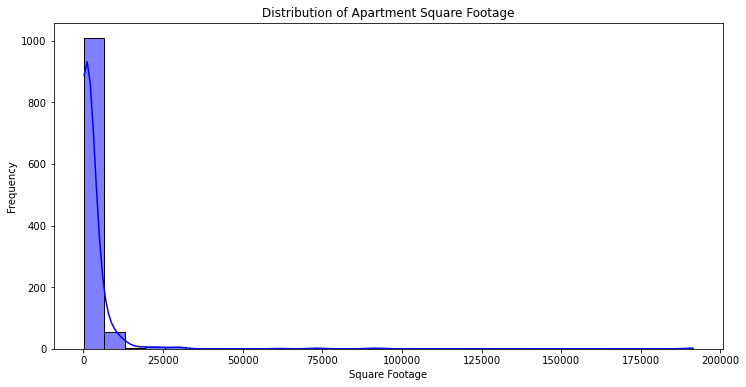

In [28]:
# Visualize the apartment square footage
plt.figure(figsize=(12, 6))
sns.histplot(tx_apar_data['squareFootage'], kde=True, color='blue', bins=30)
plt.title('Distribution of Apartment Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.show()

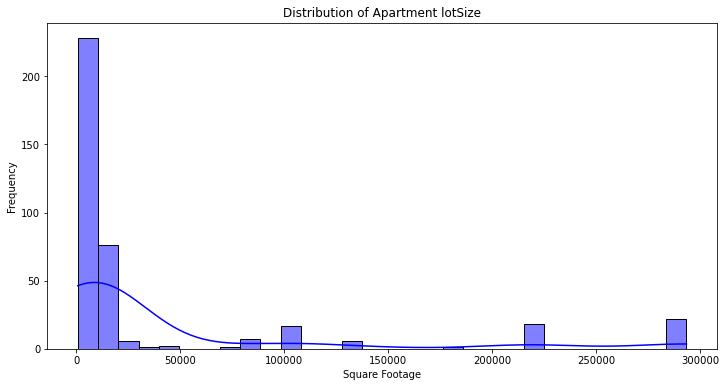

In [29]:
# Visualize the apartment Lot area
plt.figure(figsize=(12, 6))
sns.histplot(tx_apar_data['lotSize'], kde=True, color='blue', bins=30)
plt.title('Distribution of Apartment lotSize')
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.show()

# 2. Correlation
## We also want to investigate if there is correlation between the squareFootage and roomCount, given the filtered data that contains both these two information.

In [32]:

# drop the entries that do not have squareFoortage information
filtered_data_squarefootage = tx_apar_data.dropna(subset=['squareFootage'])
filtered_data_lotsize = tx_apar_data.dropna(subset=['lotSize'])

# # Plots are the same since automatically ignore NA
# # Visualize the apartment square footage
# plt.figure(figsize=(12, 6))
# sns.histplot(filtered_data_squarefootage['squareFootage'], kde=True, color='blue', bins=30)
# plt.title('Distribution of Apartment Square Footage')
# plt.xlabel('Square Footage')
# plt.ylabel('Frequency')
# plt.show()

# # Visualize the apartment Lot area
# plt.figure(figsize=(12, 6))
# sns.histplot(filtered_data_lotsize['lotSize'], kde=True, color='blue', bins=30)
# plt.title('Distribution of Apartment lotSize')
# plt.xlabel('Square Footage')
# plt.ylabel('Frequency')
# plt.show()

In [74]:
filtered_data_both = filtered_data_squarefootage[
    filtered_data_squarefootage['features'].apply(lambda x: isinstance(x, dict) and 'roomCount' in x)
]

In [80]:
# Extract 'roomCount' from the 'features' dictionary into a new column
filtered_data_both['roomCount'] = filtered_data_both['features'].apply(lambda x: x.get('roomCount'))
# See what information is contained
filtered_data_both.iloc[0]
# We see we successfully created a new (seperate) column that contains the roomCount information.

/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_75214/2262817831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_both['roomCount'] = filtered_data_both['features'].apply(lambda x: x.get('roomCount'))


id                                    3421-Ave-N,-Galveston,-TX-77550
formattedAddress                      3421 Ave N, Galveston, TX 77550
addressLine1                                               3421 Ave N
addressLine2                                                     None
city                                                        Galveston
state                                                              TX
zipCode                                                         77550
county                                                      Galveston
latitude                                                    29.291903
longitude                                                  -94.804125
propertyType                                                Apartment
yearBuilt                                                      1967.0
lastSaleDate                                 2013-09-05T00:00:00.000Z
squareFootage                                                  5524.0
lotSize             

In [82]:
print(filtered_data_both[['squareFootage', 'roomCount']].describe())

       squareFootage  roomCount
count      30.000000  30.000000
mean     5350.400000   8.233333
std      3774.098738   2.314621
min       724.000000   1.000000
25%      3415.000000   8.000000
50%      4552.000000   8.000000
75%      6064.000000  10.000000
max     16398.000000  12.000000


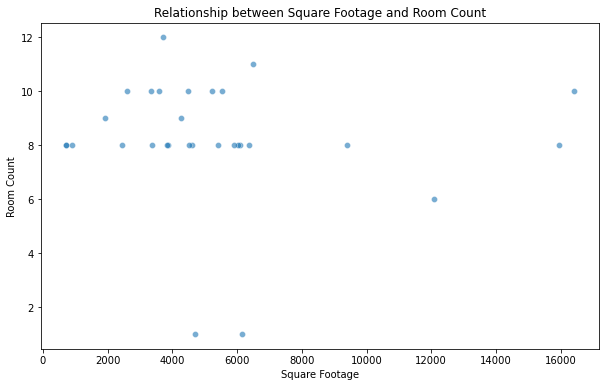

In [84]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data_both, x='squareFootage', y='roomCount', alpha=0.6)
plt.title('Relationship between Square Footage and Room Count')
plt.xlabel('Square Footage')
plt.ylabel('Room Count')
plt.show()

In [86]:
correlation = filtered_data_both['squareFootage'].corr(filtered_data_both['roomCount'])
print(f'Pearson correlation coefficient between square footage and room count: {correlation:.2f}')

Pearson correlation coefficient between square footage and room count: -0.06


### Unfortuanltely, we don't see strong correlation between the two.
- Based on previous exploratory analysis, this could be due to imcomplete information about the roomCount.
- We want to try other parameters, like the relationship between LotArea and Squarefoot.

374


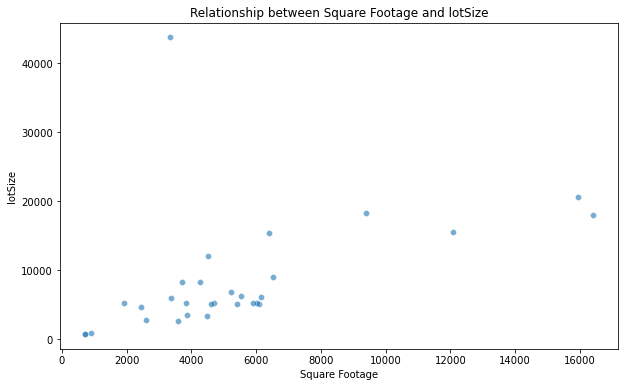

In [94]:
# Dataframe that contains both squareFootage and lotSize
filtered_data_area = tx_apar_data.dropna(subset=['squareFootage','lotSize'])
print(len(filtered_data_area))
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data_both, x='squareFootage', y='lotSize', alpha=0.6)
plt.title('Relationship between Square Footage and lotSize')
plt.xlabel('Square Footage')
plt.ylabel('lotSize')
plt.show()

In [92]:
correlation2 = filtered_data_both['squareFootage'].corr(filtered_data_both['lotSize'])
print(f'Pearson correlation coefficient between square footage and lotSize: {correlation2:.2f}')

Pearson correlation coefficient between square footage and lotSize: 0.46


In [ ]:
# Dataframe that contains both squareFootage and lotSize
filtered_data_area = tx_apar_data.dropna(subset=['squareFootage','lotSize'])
print(len(filtered_data_area))
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data_both, x='squareFootage', y='lotSize', alpha=0.6)
plt.title('Relationship between Square Footage and lotSize')
plt.xlabel('Square Footage')
plt.ylabel('lotSize')
plt.show()

### We see that there is a positive correlation of 0.46 between lotSize and footage, which increases the credibility of the data because we normally expect such positive correlation.

Based on the response from Rentcast API customter support:
- "unitCount" is used to indicate the number of individual apartment units in a multi-family building. For example, a duplex has 2 units, and a quad has 4 units. For single family properties this field is either going to be absent, or will have a value of 1.

- "roomCount" is used to indicate the total number of rooms in the property, when that information is available. It's different from bedroom/bathroom count as it counts all of the rooms, including the living room, kitchen, dining room, etc.

Therefore, based on the previous findings in "Exploring-Rentcast-API", we probably will not be able to directly use the 'UnitCount' and 'Roomcount" parameters. 
- ### However, if we decide to use the building foorprint/residential building area as a proxy, Rentcast API will be helpful.

In [145]:
def check_squareFootage_and_LotSize(data):
    """
    Prints the formatted address, square footage and lot sizefor each property in the DataFrame
    that contains these attributes.
    
    Iterates through a DataFrame of property information, checks for the presence of square footage, lot size,
    and prints out the property's formatted address alongside these attributes if they exist.
    Additionally, it counts the number of properties that contain all three attributes.
    
    Parameters:
    - data (pandas.DataFrame): A DataFrame where each row represents a property and contains
      'formattedAddress', 'squareFootage', 'lotSize', and a 'features' dictionary that may include a 'roomCount' key.
    
    Returns:
    - int: The number of properties that contain square footage and lot size.
    """
    count_contained = 0
    info = []
    valid_square_footage = data.dropna(subset=['squareFootage','lotSize'])
    for index, row in valid_square_footage.iterrows():
        formattedAddress = row['formattedAddress']
        squareFootage = row['squareFootage']
        lotSize = row['lotSize']
        
        # Check if all required attributes exist
        if pd.notna(squareFootage) and pd.notna(lotSize) is not None:
            info.append(f"Address: {formattedAddress}, Square Footage: {squareFootage}, Lot Size: {lotSize}")
            count_contained += 1
    print(f"%{100*len(info)/len(data):.3f} of the entries have both squareFootage and lotSize data.")
    
    return info

In [146]:
num_properties = check_squareFootage_and_LotSize(tx_apar_data)
len(num_properties)

%31.012 of the entries have both squareFootage and lotSize data.


374

In [144]:
#num_properties


### 2. To match datasets not only by the full address but also by utilizing string matching and adding a geographical buffer with GeoPandas.

In [37]:
# Convert the DataFrame to a GeoDataFrame
gdf_tx_apar = gpd.GeoDataFrame(
    tx_apar_data,
    geometry=gpd.points_from_xy(tx_apar_data.longitude, tx_apar_data.latitude),
    crs="EPSG:4326"
)

In [38]:
# Load the Excel file into a DataFrame
padlet_df = pd.read_excel('/Users/kd6801/Desktop/Texas_RentCast_data/padlet/Padlet - City of Galveston Texas Yelp.xlsx')

In [41]:
# Convert the DataFrame to a GeoDataFrame
gdf_padlet = gpd.GeoDataFrame(
    padlet_df,
    geometry=gpd.points_from_xy(padlet_df.Longitude, padlet_df.Latitude),
    crs="EPSG:4326"
)

In [147]:
gdf_tx_apar['geometry'] = gdf_tx_apar.geometry.buffer(0.01) 
matches = gpd.sjoin(gdf_tx_apar, gdf_padlet, how="inner", op="intersects")

/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_75214/807060569.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_tx_apar['geometry'] = gdf_tx_apar.geometry.buffer(0.01)
/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [148]:
matches

id  \
0                  4400-Ave-N,-Galveston,-TX-77550   
2         7302-Ave-P,-1-2-Ave,-Galveston,-TX-77551   
3                3102-69th-St,-Galveston,-TX-77551   
5     4925-Fort-Crockett-Blvd,-Galveston,-TX-77551   
6           4800-Seawall-Blvd,-Galveston,-TX-77551   
...                                            ...   
1192            912-Church-St,-Galveston,-TX-77550   
1193                720-Ave-K,-Galveston,-TX-77550   
1195           1804-Church-St,-Galveston,-TX-77550   
1201           402-12-17th-St,-Galveston,-TX-77550   
1204           502-Holiday-Dr,-Galveston,-TX-77550   

                                  formattedAddress             addressLine1  \
0                  4400 Ave N, Galveston, TX 77550               4400 Ave N   
2         7302 Ave P, 1/2 Ave, Galveston, TX 77551               7302 Ave P   
3                3102 69th St, Galveston, TX 77551             3102 69th St   
5     4925 Fort Crockett Blvd, Galveston, TX 77551  4925 Fort Crockett Blvd   
6           4800 Seawall Blvd, Galveston, TX 77551        4800 Seawall Blvd   
...                                            ...                      ...   
1192            912 Church St, Galveston, TX 77550            912 Church St   
1193                720 Ave K, Galveston, TX 77550                720 Ave K   
1195           1804 Church St, Galveston, TX 77550           1804 Church St   
1201           402-12 17th St, Galveston, TX 77550           402-12 17th St   
1204           502 Holiday Dr, Galveston, TX 77550           502 Holiday Dr   

     addressLine2       city state  zipCode            county   latitude  \
0            None  Galveston    TX    77550         Galveston  29.290238   
2         1/2 Ave  Galveston    TX    77551  Galveston County  29.274965   
3            None  Galveston    TX    77551         Galveston  29.268001   
5            None  Galveston    TX    77551         Galveston  29.274386   
6            None  Galveston    TX    77551  Galveston County  29.274910   
...           ...        ...   ...      ...               ...        ...   
1192         None  Galveston    TX    77550         Galveston  29.308014   
1193         None  Galveston    TX    77550  Galveston County  29.303972   
1195         None  Galveston    TX    77550  Galveston County  29.305379   
1201         None  Galveston    TX    77550  Galveston County  29.307032   
1204         None  Galveston    TX    77550         Galveston  29.310109   

      longitude  ...                 Subject  \
0    -94.814662  ...          Sonic Drive-In   
2    -94.847144  ...          Sonic Drive-In   
3    -94.835433  ...          Sonic Drive-In   
5    -94.815862  ...          Sonic Drive-In   
6    -94.813740  ...          Sonic Drive-In   
...         ...  ...                     ...   
1192 -94.777725  ...  Galveston Naval Museum   
1193 -94.774127  ...  Galveston Naval Museum   
1195 -94.787807  ...  Galveston Naval Museum   
1201 -94.786647  ...  Galveston Naval Museum   
1204 -94.771318  ...  Galveston Naval Museum   

                                                   Body  \
0     Source: yelp\nCategories: Fast Food|Burgers|Ic...   
2     Source: yelp\nCategories: Fast Food|Burgers|Ic...   
3     Source: yelp\nCategories: Fast Food|Burgers|Ic...   
5     Source: yelp\nCategories: Fast Food|Burgers|Ic...   
6     Source: yelp\nCategories: Fast Food|Burgers|Ic...   
...                                                 ...   
1192  Source: yelp\nCategories: Historical Tours|Mus...   
1193  Source: yelp\nCategories: Historical Tours|Mus...   
1195  Source: yelp\nCategories: Historical Tours|Mus...   
1201  Source: yelp\nCategories: Historical Tours|Mus...   
1204  Source: yelp\nCategories: Historical Tours|Mus...   

                                             Attachment  Attachment caption  \
0     https://www.yelp.com/biz/sonic-drive-in-galves...         Website Url   
2     https://www.yelp.com/biz/sonic-drive-in-galves...         Website Url   
3     https://

In [149]:
for index, row in matches.iterrows():
    best_match_score = 0
    best_match_address = None
    for address in padlet_df['Location']:  # Replace 'Address_Column_Name' with the actual column name
        score = fuzz.ratio(row['formattedAddress'].lower(), address.lower())
        if score > best_match_score:
            best_match_score = score
            best_match_address = address
    # Assuming you want to print or store the best match address and its score
    print(f"Best match for {row['formattedAddress']}: {best_match_address} with a score of {best_match_score}")

Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 8610 Seawall Blvd, Galveston, TX 77554: 8710 Seawall Blvd, Galveston, TX 77554 with a score of 9

Best match for 7400 Jones Dr, Apt 112, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3416, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3432, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2634, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2823, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 836, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 532, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 436, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 938, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 214, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 722, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Ce

Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 3, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best mat

Best match for 7400 Jones Dr, Apt 121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1812, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1813, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3832, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1213, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7302 Stewart Rd, Apt 21, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 8008 Seawall Blvd, # 1795, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 88
Best match for 6003 Ave S, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 2112 Victory St, Galveston, TX 77551: 2412 61st St, Galveston, TX 77551 with a score of 84
Best match for 1401 Bayou Shore Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 80
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match fo

Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a sco

Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 3602 Princeton St, Unit Down, Galveston, TX 77554: 3606 89th St, Galveston, TX 77554 with a score of 71
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match fo

Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1912 50th St, Galveston, TX 77

Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 6907 

Best match for 7400 Jones Dr, Apt 2114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 623, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3426, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City B

Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match fo

Best match for 8100 Seawall Blvd, Apt 381, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 8100 Seawall Blvd, Apt 131, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 w

Best match for 6424 Central City Blvd, Apt 811, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 638, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 838, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 6424 Central City Blvd, Apt 821, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 738, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 2, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84


Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 7400 Jones Dr, Apt 1923, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2731, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # C, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 2432, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1922, Galveston, TX 

Best match for 7400 Jones Dr, Apt 3614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 210, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 315, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 370, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551

Best match for 7400 Jones Dr, Apt 2535, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2537, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2528, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2538, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2527, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7440 Jones Dr, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 97
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 5218 Ave P, Unit 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87

Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1522, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3314, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1024, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 

Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 234, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 231, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best

Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, 

Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 

Best match for 7400 Jones Dr, Apt 3531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3832, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galvesto

Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a sco

Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 3602 Princeton St, Unit Down, Galveston, TX 77554: 3606 89th St, Galveston, TX 77554 with a score of 71
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a sc

Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match f

Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, 

Best match for 7400 Jones Dr, Apt 2527, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7440 Jones Dr, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 97
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 5218 Ave P, Unit 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX

Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1522, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 7820 Seawall Blvd, Apt 109, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 234, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96

Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39

Best match for 7400 Jones Dr, Apt 2223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3234, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1812, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1813, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7302 Stewart Rd, Apt 21, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 8008 Seawall Blvd, # 1795, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 88
Best match for 6003 Ave S, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 2112 Victory St, Galveston, TX 77551: 2412 61st St, Galveston, TX 77551 with a score of 8

Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400

Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 

Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score o

Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 3602 Princeton St, Unit Down, Galveston, TX 77554: 3606 89th St, Galveston, TX 77554 with a score of 71
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, T

Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 8100 Seawall Blvd, Apt 201, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston,

Best match for 5218 Ave P, Unit 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX

Best match for 7400 Jones Dr, Apt 1024, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3436, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2111, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 C

Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best m

Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, 

Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 803, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 1313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551:

Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1025, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 736, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 8100 Seawall Blvd, Apt 122, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 222, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Bl

Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 3602 Princeton St, Unit Down, Galveston, TX 77554: 3606 89th St, Galveston, TX 77554 with a score of 71
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 

Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 164, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galve

Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 3511 Dominique Dr, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 68
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galvesto

Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 611, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2114, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 1122, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1119, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galvest

Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Apt 381, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with 

Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Ce

Best match for 7820 Seawall Blvd, Apt 103, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 3222 69th St, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 100
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400

Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550

Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 3602 Princeton St, Unit Down, Galveston, TX 77554: 3606 89th St, Galveston, TX 77554 with a score of 71
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a sc

Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match f

Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 164, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galve

Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston, TX 77551: 8020 Stewart Rd, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 

Best match for 7400 Jones Dr, Apt 3413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3436, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2111, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galv

Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 8100 Seawall Blvd, Apt 374, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a sco

Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Ce

Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 

Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX

Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a sco

Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Gal

Best match for 6424 Central City Blvd, Apt 834, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
B

Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston

Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 5218 Ave P, Unit 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston

Best match for 7400 Jones Dr, Apt 625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2111, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 275, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 2828 61st St, Apt 108, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77

Best match for 8100 Seawall Blvd, Apt 231, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 7755

Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Ce

Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 7820 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 227, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 204, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 103, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 3222 69th St, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 100
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort C

Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 8610 Seawall Blvd, Galveston, TX 77554: 8710 Seawall Blvd, Galveston, TX 77554 with a score of 97
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 2105 Victory Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 79
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Galveston, TX 77551: 4910 Seawall Blvd, Galveston, TX 77551 with a score of 95
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 19

Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1115, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 112, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2013, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 6424 Central City Blvd, Apt 1033, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1139, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 918, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 836, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 532, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 436, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 938, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Ga

Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 8100 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2828 61st St, Apt 105, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 826, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 917, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1212, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 928, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 wi

Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3614 Yale St, Apt 2, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 77
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 3108 69th 

Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City 

Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 3505 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with 

Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best matc

Best match for 7400 Jones Dr, Apt 611, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 623, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3426, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX

Best match for 6424 Central City Blvd, Apt 1119, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 wi

Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 8100 Seawall Blvd, Apt 131, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 183, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 7221 Avenue R Unit C, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 81
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 85
Best match for 7302 Ave P, 1/2 # 1809, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 5127 Ave, Galvesto

Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 8

Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 164, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galve

Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston, TX 77551: 8020 Stewart Rd, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81

Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 275, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 2828 61st St, Apt 108, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 8100 Seawall Blvd, Apt 276, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 373, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 7755

Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 8100 Seawall Blvd, Apt 374, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 w

Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, 

Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 

Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 1401 Bayou Shore Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 80
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551:

Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400

Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 

Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score o

Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 8100 Seawall Blvd, Apt 131, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 183, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 7221 Avenue R Unit C, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 81
Best match for 5218 Ave P, Rear, Galvesto

Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 924, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 811, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 638, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 838, Galveston, TX 77551: 6424 Ce

Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551

Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2312, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 8610 Seawall Blvd, Galveston, TX 77554: 8710 Seawall Blvd, Galveston, TX 77554 with a score of 97
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best 

Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1115, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 736, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 632, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 637, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1033, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1139, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 918, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 8100 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2828 61st St, Apt 105, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 826, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 917, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1212, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 wi

Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3614 Yale St, Apt 2, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 77
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 2

Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a

Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 164, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 wit

Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston, 

Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1522, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3314, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1024, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3436, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galv

Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 7820 Seawall Blvd, Apt 109, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 234, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 231, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 3918 Ursuline, G

Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3438, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39

Best match for 7400 Jones Dr, Apt 1221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1812, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1813, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3832, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1313, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7302 Stewart Rd, Apt 21, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 8008 Seawall Blvd, # 1795, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 88
Best match for 6003 Ave S, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 2112 Victory St, Galveston, TX 77551: 2412 61st St, Galveston, TX 77551 with a score of 84
Best match for 1401 Bayou Shore Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 

Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 6907 Weis Dr, Unit 2762, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a s

Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3426, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 64

Best match for 6424 Central City Blvd, Apt 1122, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1119, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galvest

Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 381, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 4715 Ave P, 1/2 Rear, Galvesto

Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Ce

Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 7820 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 227, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 204, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 103, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 3222 69th St, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 100
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 

Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, G

Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a sco

Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for

Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 164, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston,

Best match for 7400 Jones Dr, Apt 2138, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2136, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2535, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2537, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2528, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2538, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2527, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7440 Jones Dr, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 97
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a sco

Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2133, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 642

Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Ce

Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1915 45th St, Unit 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 7400 Jones Dr, Apt 3021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match

Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 3, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best match for 6424 Central Ci

Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3632, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3604 Princeton St, Unit Up, Galveston, TX 77554: 601 Tremont St, Galveston, TX 77550 with a score of 73
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with 

Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 3511 Dominique Dr, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 68
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galvesto

Best match for 7400 Jones Dr, Apt 2111, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 275, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 2828 61st St, Apt 108, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 8100 Seawall Blvd, Apt 276, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 381, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City 

Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Ce

Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galvesto

Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 3421 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 8610 Seawall Blvd, Galveston, TX 77554: 8710 Seawall Blvd, Galveston, TX 77554 with a score of 97

Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 524, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424

Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 8100 Seawall Blvd, Apt 122, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 222, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galvest

Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 3602 Princeton St, Unit Down, Galveston, TX 77554: 3606 89th St, Galveston, TX 77554 with a score of 71
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX

Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a

Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 164, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston,

Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Galveston, TX 77551: 4910 Seawall Blvd, Galveston, TX 77551 with a score of 95
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2407 40th St, Unit Studio, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 76
Best match for 7400 Jones Dr, Apt 2536, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2115, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2526, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best mat

Best match for 7400 Jones Dr, Apt 2534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3416, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3432, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2634, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2833, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3025, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 1033, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1139, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 918, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 836, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 532, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 436, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 938, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2828 61st St, Apt 105, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 826, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 917, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1212, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 928, Galveston, TX 77551: 6424 Central City Blvd, Galve

Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3614 Yale St, Apt 2, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 77
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 

Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City 

Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 

Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston, TX 77551: 8020 Stewart Rd, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 

Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3314, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1024, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3436, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2111, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 275, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 2828 61st St, Apt 108, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 8100 Seawall Blvd, Apt 276, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 775

Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 8100 Seawall Blvd, Apt 374, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Ce

Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 7820 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 227, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 204, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7

Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, G

Best match for 3028 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 

Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central

Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Apt 381, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a

Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, T

Best match for 7820 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 227, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 204, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 103, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 3222 69th St, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 100
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match 

Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Ave, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 86
Best match for 3702 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 

Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 6907 Weis Dr, Unit 2762, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 7

Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 w

Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match fo

Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Apt 381, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a

Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 924, Galveston, TX 77551: 6424 Ce

Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 7400 Jones Dr, Apt 1923, Galveston, 

Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central C

Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 8610 Seawall Blvd, Galveston, TX 77554: 8710 Seawall Blvd, Galveston, TX 77554 with a score of 97
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 2105 Victory Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 79
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Galveston, TX 77551: 4910 Seawall Blvd, Galveston, TX 77551 with a score of 95
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 1917

Best match for 7400 Jones Dr, Apt 3422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2133, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 7820 Seawall Blvd, Apt 109, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 8

Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX

Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 7820 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 227, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 204, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 103, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 3222 69th St, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 100
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort C

Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 2105 Victory Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 79
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2828 

Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 736, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 632, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 637, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1033, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1139, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 2828 61st St, Apt 105, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 826, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 917, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1212, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 928, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 w

Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2927

Best match for 6424 Central City Blvd, Apt 738, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 2, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 2828 61st St, Apt 503, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 614, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3330 Avenue O 1/2 Unit B, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 82
Best match for 6424 Central City Blvd, Apt 834, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match 

Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610,

Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 3421 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 2105 

Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 

Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galves

Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 7221 Avenue R Unit C, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 81
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Gal

Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1814 33rd St, Apt 2, Galves

Best match for 7228 Stewart Rd, Apt 3, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 642

Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best m

Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2822 Bernardo De Galvez, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 74
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3415 Ave Q, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 91
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston, TX 77551: 8020 Stewart Rd, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a sco

Best match for 7400 Jones Dr, Apt 2833, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2133, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Ce

Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2407 Gerol Dr, Unit 1644, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 7

Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a

Best match for 7400 Jones Dr, Apt 3213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Gal

Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2908 Ave P, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 3515 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2407 40th St, Unit Studio, Gal

Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 524, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 736, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 632, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 637, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1033, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 wi

Best match for 1308 31st St, Galveston, TX 77550: 718 41st St, Galveston, TX 77550 with a score of 92
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 

Best match for 2828 61st St, Apt 206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 738, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 2, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 2828 61st St, Apt 503, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 614, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3330 Avenue O 1/2 Unit B, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 82
Best match for 6424 Central City Blvd, Apt 834, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score 

Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galvesto

Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3232, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 3421 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 2105 Victory Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 79
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline 

Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jo

Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 

Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a sc

Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 7221 Avenue R Unit C, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 81
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 85
Best match for 7302 Ave P, 1/2 # 1809, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a scor

Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with 

Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3632, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1222, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2223, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best 

Best match for 8020 Stewart Rd, Galveston, TX 77551: 8020 Stewart Rd, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 3511 Dominique Dr, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 68
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galve

Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 611, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 8100 Seawall Blvd, Apt 275, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 2828 61st St, Apt 108, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77

Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 8100 Seawall Blvd, Apt 374, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 w

Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Ce

Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 3605 Ave M, Apt Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, 

Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 2112 Victory St, Galveston, TX 77551: 2412 61st St, Galveston, TX 77551 with a score of 84
Best match for 1401 Bayou Shore Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 80
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554:

Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 6907 Weis Dr, Unit 2762, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3426, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 64

Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119

Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 8100 Seawall Blvd, Apt 131, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 183, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3730 A

Best match for 6424 Central City Blvd, Apt 838, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 6424 Central City Blvd, Apt 821, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 738, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 2, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 2828 61st St, Apt 503, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 614, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match 

Best match for 7400 Jones Dr, Apt 2422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2731, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # C, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 2432, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 740

Best match for 8100 Seawall Blvd, Apt 370, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 8100 Seawall Blvd, Apt 201, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, 

Best match for 3515 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2407 40th St, Unit Studio, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 76
Best match for 7400 Jones Dr, Apt 2536, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2115, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2526, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2138, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2136, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2535, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2537, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 621, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1025, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 736, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 632, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galve

Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 2808 Ave M, Apt 3, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 4, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 5, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 6, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Bes

Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 79
Best match for 2828 61st St, Apt 206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 738, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 2, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 2828 61st St, Apt 503, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 614, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3330 Avenue O 1/2 Unit B, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 82
Best match for 2808 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 6424 Central City Blvd, Apt 834, Galv

Best match for 2806 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 291

Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 421, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 1219 31st St, Galveston, T

Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston, TX 77551 with a score of 67
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 

Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1522, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3314, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1024, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3436, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 642

Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2910 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 

Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2407 Gerol Dr, Unit 1644, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1915 45th St, Unit 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 7400 Jones Dr, Apt 3021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score 

Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a

Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2915 Ball, Unit 2915, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 3505 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a 

Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 3421 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 2105 

Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galvest

Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central

Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 7221 Avenue R Unit C, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 81
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear,

Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 728, Galv

Best match for 7400 Jones Dr, Apt 2223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3234, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1812, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1813, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 13, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Uni

Best match for 7400 Jones Dr, Apt 2537, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2528, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2538, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2527, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7440 Jones Dr, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 97
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 5218 Ave P, Unit 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score

Best match for 7400 Jones Dr, Apt 1023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2634, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2833, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a

Best match for 6424 Central City Blvd, Apt 214, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 722, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Ce

Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 78
Best match for 3001 Ave O, Unit Down, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 79
Best match for 2002 27th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 94
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3423 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 7

Best match for 2002 27th St, Apt 4, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 8, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1110 36th St, Unit Up, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Ap

Best match for 7400 Jones Dr, Apt 1312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Ce

Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galvest

Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Be

Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 8100 Seawall Blvd, Apt 131, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 183, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 7221 Avenu

Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 924, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 811, Galveston, TX 77551: 6424 Ce

Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galvesto

Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 724, Galveston, TX 77551: 7400 Jones Dr, Galveston

Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 91
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best m

Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3035, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a sco

Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N

Best match for 6424 Central City Blvd, Apt 834, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
B

Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 8100 Seawall Blvd, Apt 369, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston

Best match for 7400 Jones Dr, Apt 2138, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2136, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2535, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2537, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2528, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2538, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2527, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7440 Jones Dr, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 97
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a sco

Best match for 7400 Jones Dr, Apt 2833, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2133, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 642

Best match for 2828 61st St, Apt 1212, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 928, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 89
Best match for 6424 Central City Blvd, Apt 214, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 722, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Gal

Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2407 Gerol Dr, Unit 1644, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550

Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galve

Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 3505 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 4420 Ave K, Ave, Galveston, TX 77550:

Best match for 7400 Jones Dr, Apt 2518, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston

Best match for 7400 Jones Dr, Apt 3413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3436, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1625, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2111, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 7820 Seawall Blvd, Apt 109, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 8100 Seawall Blvd, Apt 234, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 231, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5

Best match for 7400 Jones Dr, Apt 3021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 731, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 3, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best mat

Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3632, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1222, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1721, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3604 Princeton St, Unit Up, Galveston, TX 77554: 601 Tremont St, Galveston, TX 77550 with a score of 73
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 73

Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a scor

Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galve

Best match for 6424 Central City Blvd, Apt 928, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 89
Best match for 6424 Central City Blvd, Apt 214, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 722, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City

Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2627 Ave K, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, U

Best match for 6424 Central City Blvd, Apt 611, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 2509 Ave K, Apt 3, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2002 27th St, Apt 1, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 5, Ga

Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 6424 Central City Fp Blvd, # C, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score

Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 14, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Apt 11, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galve

Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 6907 Weis Dr, Unit 2762, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 7400 Jones 

Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 611, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 623, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston

Best match for 8100 Seawall Blvd, Apt 276, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 373, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 613, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1122, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1119, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Ce

Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 135, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 179, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 8100 Seawall Blvd, Apt 374, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 w

Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3018, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3027, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3031, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Ce

Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 3605 Ave M, Apt Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galves

Best match for 7400 Jones Dr, Apt 1812, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1813, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3832, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Aven

Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 6907 Weis Dr, Unit 2762, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 7400 Jones Dr, Apt 2124, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2533, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3426, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 64

Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77

Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for

Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Ce

Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 7820 Seawall Blvd, Apt 223, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 227, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 204, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 103, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 3222 69th St, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 100
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort C

Best match for 7400 Jones Dr, Apt 1724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 1401 Bayou Shore Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 80
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 6911 Ave O, Galveston, TX 77551: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 3614 Yale St, Galveston, TX 77554: 3134 83rd St, Galveston, TX 77554 with a score of 85
Best match for 1511 36th St, Galveston, TX 77550: 51

Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400

Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 

Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a sc

Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1126, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 8100 Seawall Blvd, Apt 131, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 94
Best match for 

Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 924, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 811, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 638, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 838, Galveston, TX 77551: 6424 Ce

Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551

Best match for 7400 Jones Dr, Apt 1911, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 1827 And

Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 1411 34th St, Unit B, Galveston, TX 77550: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 80
Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1411 34th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111

Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1014, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1910 Ave N, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2910 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, T

Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2927 Ave L, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 2519 Ave P, 1/2 Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 2107 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2315 Be

Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2002 27th St, Apt 1, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 5, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 7, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 4, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 8, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Apt 811, Galveston, TX 77

Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 6424 Central City Fp Blvd, # C, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galvest

Best match for 3916 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2915 Ave H, Church St Unit 2925, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 76
Best match for 6003 Ave S, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 2112 Victory St, Galveston, TX 77551: 2412 61st St, Galveston, TX 77551 with a score of 84
Best match for 1401 Bayou Shore Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 80
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best mat

Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 94
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best matc

Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 

Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 132

Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2609 Ave L, Galveston, TX 77550

Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2121 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 924, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 811, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a sco

Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 3510 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 7755

Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2 Apt 10, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 77
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 13, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match f

Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston,

Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 1919 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2516 Ave K, Apt 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1037, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 325, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Bl

Best match for 6424 Central City Blvd, Apt 1119, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2924 Ave P, 1/2 Unit 2, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with 

Best match for 2811 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 3116 Ave L, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central C

Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88

Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galve

Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2915 Ball, Unit 2915, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 1513 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 91
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 3505 Ave, Galveston, TX 77550: 1108 Ave L, Galves

Best match for 1101 21st And 2107 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 2014 Ave M, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1101 21st And 2101 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 2828 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 91
Best match for 3702 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galvest

Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3116 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 3116 Ave L, Apt 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 1411 34th St, Unit 

Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 611, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 2828 61st St, Apt 108, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 613, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 7

Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 2924 Ave P, 1/2 Unit 1, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2811 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4424 Ave L, Gal

Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3438, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 731, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 3, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best mat

Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3632, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1222, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2223, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 2710 Ave P, 1/2 Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 28

Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 8020 Stewart Rd, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1522, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3314, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1024, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 642

Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 7820 Seawall Blvd, Apt 109, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 8

Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, A

Best match for 7400 Jones Dr, Apt 1222, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3234, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1422, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3604 Princeton St, Unit Up, Galveston, TX 77554: 601 Tremont St, Galveston, TX 77550 with a score of 73
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 A

Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2822 Bernardo De Galvez, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 74
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3415 Ave Q, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 91
Best match for 1910 Ursuline, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1312-16 26th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 88
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best mat

Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Be

Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77

Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Ce

Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1914 23rd St, Unit 2, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 

Best match for 2711 Ave K, Unit 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2 Apt 10, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 77
Best match f

Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 2105 Victory Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 79
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 8100 Seawall Blvd, Galveston, TX 77551: 4910 Seawall Blvd, Galveston, TX 77551 with a score of 95
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2407 40th St, Unit Studio, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 76
Best match for 7400 Jones Dr

Best match for 7400 Jones Dr, Apt 112, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3416, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3432, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2634, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2823, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 938, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424

Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1803, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 7820 Seawall Blvd, Apt 109, Galveston, TX 77551: 7310 Seawall Blvd, Apt 505, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, 

Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7228 Stewart Rd, Apt 3, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 84
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best mat

Best match for 7400 Jones Dr, Apt 1721, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3234, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 121, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1812, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3604 Princeton St, Unit Up, Galveston, TX 77554: 601 Tremont St, Galveston, TX 77550 with a score of 73
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 4

Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3415 Ave Q, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 91
Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston

Best match for 7400 Jones Dr, Apt 3025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2133, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a

Best match for 6424 Central City Blvd, Apt 722, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 315, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 612, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Ce

Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2927 Ave L, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 78
Best match for 3001 Ave O, Unit Down, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 79
Best match for 2002 27th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 94
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3423 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 3108 69th

Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1110 36th St, Unit Up, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best ma

Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2915 Ball, Unit 2915, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with

Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston,

Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 703, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1411 34th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 2823 Ave K, # F2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2201 Market St, Ste 603, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1012 20th St, Apt 1, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1012 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 

Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 914 20th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 83
Best match fo

Best match for 6424 Central City Blvd, Apt 837, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galves

Best match for 2808 Ave M, Apt 3, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 4, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 5, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 6, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 1308 31st St, Galveston, TX 77550: 718 41st St, Galveston, TX 77550 with a score of 92
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2101 Avenue K Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match fo

Best match for 6424 Central City Blvd, Apt 821, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 79
Best match for 2828 61st St, Apt 206, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 738, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1526 22nd Rear St, Unit 1, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 2828 61st St, Apt 503, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 614, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3330 Avenue O 1/2 Unit B, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 82
Best match for 2

Best match for 2828 61st St, Apt 901, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 77
Best match for 3028 Ave M, Unit A1UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2111 Post Office St, Apt 4, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 2915 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 100
Best match for 2806 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1709 Ave L, Unit 2UP, Galveston, TX 77550: 1108 Ave L, Ga

Best match for 2502 Ave L, Apt 16, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2711 Ave K, Unit 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave

Best match for 3421 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2505 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 96
Best match for 2112 Victory Ave, Galveston, TX 77551: 2328 Strand Ave, Galveston, TX 77550 with a score of 79
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galv

Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2201 Market St, Ste 701, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 106, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 90
Best match for 2201 Market St, Ste 801, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504, Galveston,

Best match for 6424 Central City Blvd, Apt 436, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 938, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Ga

Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match 

Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1814 Ave M, 1/2 A

Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91

Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1910 Ave N, Apt 5, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 2213 Ave K, Apt 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 1223 20th St, Unit Up, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 81
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galvesto

Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1025, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 1821 Broadway St, Apt 3, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Bl

Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2315 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Ave, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 86
Best match for 2319 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1101 21st And 2107 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77


Best match for 2119 Strand St, Unit 2B, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston, TX 77551 with a score of 67
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 600 19th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1623 Ave N, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with

Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2516 Ave K, Apt 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1818 Church St, Unit 3, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1718 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best matc

Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 1906 23rd St, Unit A, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 86
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 1801 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 97
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 2305 55th St, Apt 2, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1806 Church St, Unit 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best mat

Best match for 1617 17th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 19

Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2104 Strand St, Apt 4N, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 77
Best match for 3028 Ave M, Unit A1UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2111 Post Office St, Apt 4, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 2915 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 100
Best match for 1320 Ave N, 1/2 # Up, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 2118 1/2 Strand St, Unit 201, Galveston, TX 77550: 2119 Strand 

Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2 Apt 10, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 77
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 1519 Avenue M # A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 87
Best match for 2711 Av

Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Galveston

Best match for 2201 Market St, Ste 701, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 106, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 90
Best match for 2201 Market St, Ste 801, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118

Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1327 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 1327 Ave M, 1/2 Apt 5, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1628 1628 Ave, # K3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 7

Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 600 19th St, Apt 3, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1511 22nd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 81
Best match for 600 19th St, Apt 17, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2808 Ave M, Apt 3, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 4, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82

Best match for 2509 Ave K, Apt 3, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, Ave Unit Dn, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 2002 27th St, Apt 1, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 5, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 7, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 4, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 8, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a sc

Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Str

Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 14, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Apt 11, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2317 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave

Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2822 Bernardo De Galvez, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 74
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3415 Ave Q, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 91
Best match for 1910 Ursuline, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1312-16 26th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 88
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 621 Moody St, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 91
Best mat

Best match for 2115 Broadway Ave, Unit Rear, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 81
Best match for 2214 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2108 Church St, Apt 302, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 2118 1/2 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 92
Best match for 2101 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 70
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2101 Ave P, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston

Best match for 1908 Church St, Apt 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2811 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1821 Broadway St, Apt 5, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best matc

Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 600 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2107 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2315 Bernardo De Galvez, Unit 3, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 78
Best match for 600 19th St, Apt 8, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 3001 Ave O, Unit Down, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 79
Best match for 2002 27th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 94
Best match for 2213 Ave K, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best matc

Best match for 1914 23rd St, Unit 2, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1624 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 1624 Sealy St, Apt 201, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 82
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Be

Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 2711 Ave K, Unit 10, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 1927 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2702 Ave K, Galveston, TX 77550: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 1305 28th St, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 92
Best match for 1805 Tremont, Galveston, TX 77550: 601 Tremont St, Galveston, TX 77550 with a score of 88
Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1623 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 2, Galveston, TX

Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 1924 Ave O, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 63

Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 8100 Seawall Blvd, Apt 122, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 8100 Seawall Blvd, Apt 222, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galvest

Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3219 69th St, Galveston, TX 77551: 3219 69th St, Galveston, TX 77551 with a score of 100
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 

Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 8100 Seawall Blvd, Apt 302, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 96
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 8100 Seawall Blvd, Apt 215, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 98
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4305 Ave R, 1/2, Galveston, TX

Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1108 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 100
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1107 13th St, Unit 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, T

Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2823 Ave K, # F2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2201 Market St, Ste 603, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1012 20th St, Apt 1, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1012 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1923 Broadway St, Apt 2, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of

Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1910 Ave N, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2315 Strand St, Ste 2D, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Bes

Best match for 1511 22nd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 81
Best match for 600 19th St, Apt 17, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1002 11th St, Apt 7, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 1002 11th St, Apt 2, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 2808 Ave M, Apt 3, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 4, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best 

Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 815 10th St, Unit Down, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 78
Best match for 600 19th St, Apt 6, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1818 23rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2315 Strand St, Ste 2C, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1718 35th St, # 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 85
Best match for 2118 1/2 Strand St, Unit 210, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 7755

Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave, Apt 312, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 77
Best match for 2201 Market St, Ste 706, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 1006, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1007, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 705, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best

Best match for 1519 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1322 Ave L, Unit 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1408 Mechanic St, # 1, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 86
Best matc

Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1407 Broadway St, Galveston, TX 77550: 14

Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 807 17th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 3116 Ave L, Apt 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2109 Ave P, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1506 Sealy St, Unit 1, Galve

Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1009 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 914 20th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 83
Best match for 2119 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2119 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1409 14th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2121 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2121 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 10, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 

Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 2116 Strand St, Apt 208, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 818 13th St, Unit 818, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 80
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1408 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 2104 Strand St, Apt 4S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Ga

Best match for 1015 26th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 1526 Harborside Dr, Unit 4037, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 1617 17th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match 

Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1128 K Ave Unit C, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for

Best match for 2102 Ave O, 1/2 St Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 74
Best match for 1927 Ave M, 1/2 Apt 4, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 18, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 11, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1519 Avenue M Unit A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 2711 Ave K, Unit 10, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score 

Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Ave, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 86
Best match for 2319 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1101 21st And 2107 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 2014 Ave M, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1101 21st And 2101 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 1119 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 91
Best match for 1819 Broadway St, Galveston, TX 77550: 2618 Broadway St, Galveston, TX 77550 with a score of 95
Best match for

Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1107 13th St, Unit 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2822 Bernardo De Galvez, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 74
Best match for 4114 Ave S, 1/2, Galveston, 

Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2823 Ave K, # F2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2201 Market St, Ste 603, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1012 20th St, Apt 1, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1012 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1923 Broadway St, Apt 2, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of

Best match for 725 Broadway Ave St, Unit 3, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 82
Best match for 725 Broadway St, Apt 2, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1327 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 725 Broadway St, Apt 3, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1327 Ave M, 1/2 Apt 5, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1628 1628 Ave, # K3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galve

Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1526 22nd Rear St, Unit 2, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 2315 Strand St, Ste 2A, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best m

Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 815 Up N 10th St, Unit Up, Galveston, TX 77550: 515 1st St, G

Best match for 1207 10th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 920 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 92
Best match for 3510 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 2116 Strand St, Apt 205, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 3605 Ave M, Apt Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 525 11th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 92
Best match for 928 Post Office St, Unit 5, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 928 Post Office St, Unit 13, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 86
Be

Best match for 720 Ave K, Unit Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2502 Ave L, Apt 19, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2102 Ave O, 1/2 St Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 74
Best match for 1927 Ave M, 1/2 Apt 4, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 18, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 11, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best matc

Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2315 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Ave, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 86
Best match for 2319 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1101 21st And 2107 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 2014 Ave M, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best

Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 94
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1108 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 100
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Be

Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 703, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1327 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1411 34th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th St, Galveston, 

Best match for 725 Broadway St, Apt 8, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway Ave, Unit 8, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 717 Broadway Ave, Unit 1, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway Ave, Unit 9, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 717 Broadway Ave, Unit 2, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway Ave St, Unit 3, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 82
Best match for 725 Broadway St, Apt 2, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1327 Ave M, 1/2 Apt 6, Galvest

Best match for 2104 Strand St, Apt 4S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1814 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2609 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 7, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1017 11th St, A

Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1915 45th St, Unit 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2119 Strand St, Unit 3A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1415 Chu

Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 912 Church St, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Unit 10, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1128 K Ave Unit C, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1109 Broadway St, Apt 10, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a sc

Best match for 1110 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 3505 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 720 Ave K, Unit Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2502 Ave L, Apt 19, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2102 Ave O, 1/2 St Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 74
Best match for 1927 Ave M, 1/2 Apt 4, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 18, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2, Galvest

Best match for 2502 Ave L, Apt 14, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Apt 11, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2317 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2315 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 4506 Ave Q, 1

Best match for 725 Broadway Ave, Unit 6, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Avenue St, Unit 11, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway St, Apt 11, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 725 Broadway St, Apt 7, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1910 Ursuline, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 78
Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 7755

Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2201 Market St, Ste 701, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 106, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 90
Best match for 2201 Market St, Ste 801, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504, Galveston,

Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1228B Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 85
Best match for 1914 23rd St, Unit A, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1327 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1111 Market St, Unit 1, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 87
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2924 Ave P, 1/2 Unit 2, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 905 20th St, Apt 3, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 905 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 w

Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 2116 Strand St, Apt 208, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 818 13th St, Unit 818, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 

Best match for 1015 26th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 1526 Harborside Dr, Unit 4037, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 1617 17th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match 

Best match for 1109 Broadway St, Apt 8, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1624 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 1624 Sealy St, Apt 201, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 82
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 912 Church St, Unit 12, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 912 Church St, Unit 9, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best m

Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 1821 Broadway St, Apt 3, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1110 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a sc

Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1128 Avenue K Ave Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 79
Best match for 1128 Avenue K Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 3916 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2915 Ave H, Church St Unit 2925, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 76
Best match for 1004 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a scor

Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2908 Ave P, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 3515 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2407 40th St, Unit Studio, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 76
Best match for 1712 24th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2320 Ave P, 1/2, Galveston, TX 77

Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 403, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste

Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best ma

Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match 

Best match for 1806 Church St, Unit 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 2116 Strand St, Apt 204, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 211, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galves

Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 1617 17th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 

Best match for 1110 36th St, Unit Up, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1223 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 831, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 926, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1302, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 2828 61st St, Apt 504, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 

Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave, Apt 312, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 77
Best match for 2201 Market St, Ste 706, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 1006, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1007, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 705, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best

Best match for 2711 Ave K, Unit 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2 Ap

Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 2101 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 93
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1827 And 1708 Ave, and 19th, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 76
Best match for 3421 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2505 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 96
Best match for 4513

Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston, TX 77551 with a score of 67
Best match for 1528 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 91
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 725 Broadway St, Apt 4, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 612 9th St, Apt 3, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 612 9th St, Apt 4, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 1618 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 88
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a scor

Best match for 1707 Market St, Apt 4, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1224 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 2118 1/2 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 92
Best match for 2101 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 70
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2101 Ave P, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1919 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2516 Ave K, Apt 1

Best match for 2924 Ave P, 1/2 Unit 1, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 1908 Church St, Apt 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2811 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1708A Market St, Unit 1708A, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 83
Best match for 712 Ball St, Unit 111, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1821 Broadway St, Apt 5, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best ma

Best match for 2808 Ave M, Apt 6, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 1308 31st St, Galveston, TX 77550: 718 41st St, Galveston, TX 77550 with a score of 92
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 1510 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 12, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2101 Avenue K Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1523 21st St, Apt 4, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 85
Best match for 905 12th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match fo

Best match for 2315 Strand St, Ste 2C, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1718 35th St, # 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 85
Best match for 2118 1/2 Strand St, Unit 210, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 1220 Winnie Rear St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 82
Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 79
Best match for 1526 22nd Rear St, Unit 1, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with 

Best match for 2104 Strand St, Apt 4N, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 77
Best match for 3028 Ave M, Unit A1UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2111 Post Office St, Apt 4, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 2915 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 100
Best match for 1320 Ave N, 1/2 # Up, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 2118 1/2 Strand St, Unit 201, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 2806 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galves

Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1623 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 2902 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 2710 Ave P, 1/2 Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2502 Ave L, Apt 16, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2711 Ave K, Unit 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1401 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 

Best match for 1520 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1201 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 94
Best match for 1015 8th St, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 92
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 912 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 720 Ave K, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 89
Best match for 1923 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 1804 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Gal

Best match for 1312-16 26th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 88
Best match for 621 Moody St, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 91
Best match for 1320 Post Office St, Galveston, TX 77550: 2020 Post Office St, Galveston, TX 77550 with a score of 95
Best match for 717 Broadway St, Apt 1, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1924 24th St, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 91
Best match for 2315 Bernardo De Galvez, Unit 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 2119 Strand St, Unit 2B, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1009 9th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 92
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 

Best match for 1526 Harborside Dr, Unit 4036, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 1910 Ursuline, Unit 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1506 Sealy St, Unit 2, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 2616 Ave Q, Unit RR2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3028 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2115 Broadway Ave, Unit Rear, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 81
Best match for 2214 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2108 Church St, Apt 302, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1707 Market St, Apt 4, Galveston, TX 77550: 1306 Market St,

Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1910 Ave N, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2315 Strand St, Ste 2D, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1717 Ave M, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2910 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 802 Av

Best match for 2315 Strand St, Ste 2A, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 600 19th St, Apt 11, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 600 19th St, Apt 3, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1511 22nd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 81
Best match for 600 19th St, Apt 17, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1002 11th St, Apt 7, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83


Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 815 Up N 10th St, Unit Up, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 75
Best match for 815 Down 10th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 85
Best match for 815 Up 10th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 88
Best match for 1415 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 918 Winnie St, Apt 103, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 2121 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1215 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 99
Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Be

Best match for 712 Ball St, Unit 109, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 81
Best match for 712 Ball St, Unit 112, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1207 10th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 920 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 92
Best match for 3510 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 2116 Strand St, Apt 205, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 3605 Ave M, Apt Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 525 11th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 92
Best match for 9

Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 720 Ave K, Unit Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2502 Ave L, Apt 19, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2102 Ave O, 1/2 St Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 74
Best match for 1927 Ave M, 1/2 Apt 4, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 18, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match fo

Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2317 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2315 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Av

Best match for 725 Broadway Ave, Unit 6, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Avenue St, Unit 11, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway St, Apt 11, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 725 Broadway St, Apt 7, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1910 Ursuline, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 78
Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 7755

Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 403, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste

Best match for 725 Broadway St, Apt 9, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway St, Apt 8, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway Ave, Unit 8, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 717 Broadway Ave, Unit 1, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway Ave, Unit 9, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 717 Broadway Ave, Unit 2, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway Ave St, Unit 3, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 82
Best match for 725 Broadway St, Apt 2, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 4725 Ave R, 1/2 Apt 1, Galvest

Best match for 600 19th St, Apt 7, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1017 11th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best mat

Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1415 Church St, Unit B, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 wit

Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best match for 712 Ball St, Unit 103, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 912 Church St, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match

Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 1821 Broadway St, Apt 3, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 7

Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 1106 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1128 Avenue K Ave Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 79
Best match for 1128 Avenue K Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 3916 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2915 Ave H, Church St Unit 2925, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 76
B

Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2908 Ave P, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 1408 Mechanic St, # Up, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 85
Best match for 3515 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 909 University Blvd, Unit 907, Galveston, TX 77550: 301 University Blvd, UHC Fl 4  RM4.234, GALVESTON, TX 77555 with a score of 75
Best match for 2407 40th St, Unit Studio, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 76
Best match for 704 14th St, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 92
Best match for 1712 24th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a s

Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2109 Ave P, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1506 Sealy St, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 1315 18th St, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 94
Best match for 916 Ball St, Unit Rear, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 82
Best match for 1411 34th St, Unit B, Galveston, TX 77550: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 80
Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116

Best match for 2119 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1409 14th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2121 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2121 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 10, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2116 Strand St, Apt 201, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1015 11th St, Unit 1, Galveston, TX 77550: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 82
Best match for 1416 Avenue N 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 1624 17th St, Unit Down, Galveston, TX 77550: 312 19th St, Galveston

Best match for 1408 Mechanic R Up St, Unit Rear, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 76
Best match for 610 Ball, Apt 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1419 Church St, Unit A, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1806 Church St, Unit 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 2116 Strand St, Apt 204, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score 

Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 78
Best match for 600 19th St, Apt 8, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1117 9th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 3001 Ave O, Unit Down, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 79
Best match for 912 Church St, Apt 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 2002 27th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 94
Best match for 1418 13th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 91
Best match for 2213 Ave K, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2328 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 80
Best match for 617 18th St, 

Best match for 1910 Ave N, Apt 5, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 2213 Ave K, Apt 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 1223 20th St, Unit Up, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 81
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 916 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1128 Broadway St,

Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave, Apt 312, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 77
Best match for 2201 Market St, Ste 706, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 1006, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1007, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 705, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 606, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 505, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best

Best match for 1112 Ave M, 1/2 Rear Apt 1, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 77
Best match for 2711 Ave K, Unit 13, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1927 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 613 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 96
Best match for 912 Church St, Unit 8, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Unit 11, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1519 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 wi

Best match for 2312 41st Rear St, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2505 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 96
Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 417 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Ga

Best match for 1623 Ave N, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1818 Church St, Unit 4, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1628 Ave K, Unit 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 315 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 92
Best match for 826 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 96
Best match for 1505 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 915 11th St, Unit 2, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 82
Best match for 820 Broadway Rear St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 90
Best match

Best match for 1818 Church St, Unit 3, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1718 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Be

Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 610 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 87
Best match for 610 Ball, Apt 8, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 711 Holiday Dr, Apt 27, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 3116 Ave L, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a sco

Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1017 4d 11th St, Unit 4D, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 77
Best match for 1017 11th St, Unit 2B, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 80
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 16, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of

Best match for 2118 1/2 Strand St, Unit 210, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 615 Holiday Dr, Apt 18, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 1220 Winnie Rear St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 82
Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 79
Best match for 1526 22nd Rear St, Unit 1, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 1016 Post Office St, Unit A, Galveston, TX 77550: 2401 Post Office St, Galvesto

Best match for 928 Post Office St, Unit 2, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 2104 Strand St, Apt 4N, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 77
Best match for 3028 Ave M, Unit A1UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2111 Post Office St, Apt 4, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 2915 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 100
Best match for 1320 Ave N, 1/2 # Up, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 2118 1/2 Strand St, Unit 201, Galveston, TX 77550: 2119 Stra

Best match for 1305 28th St, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 92
Best match for 1805 Tremont, Galveston, TX 77550: 601 Tremont St, Galveston, TX 77550 with a score of 88
Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1623 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 2902 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 2710 Ave P, 1/2 Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2502 Ave L, Apt 16, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2711 Ave K,

Best match for 2828 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 91
Best match for 3702 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1616 Post Office St, Galveston, TX 77550: 1711 Post Office St, Galveston, TX 77550 with a score of 95
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1520 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 909 University Blvd, Galveston, TX 77550: 2931 Central City Blvd, Galveston, TX 77551 with a score of 77
Best match for 1201 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 94
Best match for 1015 8th St, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 92
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 912 Church St, Galveston, TX

Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400

Best match for 6424 Central City Blvd, Apt 324, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551

Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2407 Gerol Dr, Unit 1644, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a sc

Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 715, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 731, Galveston, TX 77551: 6424 Ce

Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7302 Stewart Rd, Apt 21, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 8008 Seawall Blvd, # 1795, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 88
Best match for 3916 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 6003 Ave S, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 2112 Victory St, Galveston, TX 77551: 2412 61st St, Galveston, TX 77551 with a score of 8

Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400

Best match for 6424 Central City Blvd, Apt 1137, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 317, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 wit

Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2407 Gerol Dr, Unit 1644, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a sc

Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City 

Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 7302 Stewart Rd, A

Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3016, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1511, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 

Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 105, Galveston, TX 77551: 2808 61st St, Ste 200, Galve

Best match for 7400 Jones Dr, Apt 3021, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7302 Stewart Rd, Apt 18, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7400 Jones Dr, Apt 3435, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 1615 Biovu Dr, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 77
Best match for 2828 61st St, Apt 410, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 606, Galveston, TX 7

Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Galveston, TX 77551: 2825 61st St, Galveston, TX 77551 with a score of 97
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 8701 Teichman Rd, Galveston, TX 77554: 8701 Teichman Rd, Galveston, TX 77554 with a score of 100
Best match for 7400 Jones Dr, Apt 2536, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2115, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2526, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2138, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2136, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87

Best match for 7400 Jones Dr, Apt 3025, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1126, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2133, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424

Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7820 Seawall Blvd, Apt 230, Galveston, TX 77551: 8100 Seawall Blvd, Apt 255, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best

Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 924, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 811, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 638, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 838, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 821, Galveston, TX 77551: 6424 Ce

Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 7400 Jones Dr, Apt 1923, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2422, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2731, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Fp Blvd, # C, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 2432, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1312, Galveston, TX 

Best match for 7400 Jones Dr, Apt 3614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 7

Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 94
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a sco

Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2823 Ave K, # F2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2201 Market St, Ste 603, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1012 20th St, Apt 1, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1012 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 1923 Broadway St, Apt 2, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1012 20th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 95
Be

Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galves

Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 28

Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 2116 Strand St, Apt 208, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score 

Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 6424 Central City Blvd, Apt 428, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 

Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 715, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 731, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1910 Ave N, Apt 5, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a scor

Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 6424 Central City Fp Blvd, # C, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, 

Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2118 Ave K, Unit Up, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85


Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 325 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 302 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1407 Broadway St, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 97
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 918 Winnie St 918 Ave, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 84
Best match for 1701 Strand St, Galveston, T

Best match for 820 Broadway Rear St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 90
Best match for 1907 O 1, Unit C, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 76
Best match for 1907 Avenue O 1/2 Unit A, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galvest

Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 325 Church St, Apt 212, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 325 Church St, Apt 106, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Be

Best match for 808 Sealy Ave, Unit 1, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 81
Best match for 912 Church St, Unit 13, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2 Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 4523 Avenue Q Unit B, Galveston, TX 77551: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 808 Sealy Ave Unit C, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 82
Best match for 711 Holiday Dr, Apt 39, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 1801 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 97
Best match for 1408 Mechanic R Up St, Unit Rear, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 76
Best match for 610 Ball, Apt 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 

Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 701 14th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 600 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1017 11th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2107 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1101 Broadway St, Unit 13, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 84
Best match for 2315 Bernardo De Galvez, Unit 3, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1213 1215 11th St, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 87
Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a sco

Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 2509 Ave K, Apt 3, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, Ave Unit Dn, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 2002 27th St, Apt 1, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 5, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 7, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 4, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 8, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 1110 36th St, Unit Up, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 80
Best m

Best match for 905 Post Office St, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 4C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 506, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave, Apt 312, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 77
Best match for 2201 Market St, Ste 706, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Marke

Best match for 1401 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2 Apt 10, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 77
Best match for 390

Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 402-12 17th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 90
Best match for 1924 Ave O, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 502 Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 94
Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX

Best match for 7400 Jones Dr, Apt 1622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2113, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 7400 Jones Dr, Apt 3026, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 616, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1021, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 6424 Central City Blvd, Apt 723, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 328, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 213, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 234, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1127, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 

Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1133, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 6424 Central City Blvd, Apt 817, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 228, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 334, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 219, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a 

Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a

Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1110 36th St, Unit Up, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt

Best match for 7400 Jones Dr, Apt 3213, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1912, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 323, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for Champions Park, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1026, Galveston, TX 77551: 6424 Central City Blvd, Galvesto

Best match for 918 Winnie St 918 Ave, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 84
Best match for 1701 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 320 Market St, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 96
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2908 Ave P, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 1408 Mechanic St, # Up, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 85
Best match for 3515 Ave R, R

Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 807 17th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 3116 Ave L, Apt 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2109 Ave P, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 4009 Ave O, Rea

Best match for 325 Church St, Apt 212, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 325 Church St, Apt 106, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1009 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 914 20th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 83
Best match for 2119 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2119 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 

Best match for 712 Ball St, Unit 111, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1821 Broadway St, Apt 5, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 610 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 87
Best match for 100 Market St, Unit 92, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 610 Ball, Apt 8, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 711 Holiday Dr, Apt 27, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 w

Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 1510 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 12, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2101 Avenue K Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1523 21st St, Apt 4, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 85
Best match for 905 12th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2627 Ave K, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 10

Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 815 10th St, Unit Down, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 78
Best match for 918 Winnie St, Apt 101, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 912 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 918 Winnie St, Apt 100, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 1, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 918 Winnie St, Apt 107, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 5, Galveston, TX 77550: 1903 Church St, Galveston

Best match for 1109 Broadway St, Apt 10, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 712 Ball St, Unit 113, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 712 Ball St, Unit 109, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 81
Best match for 712 Ball St, Unit 112, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 100 Market St, Apt 59, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 1207 10th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 4914 Ave, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 84
Best match for 920 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 92
Best match for 3510 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83

Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 1821 Broadway St, Apt 3, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1110 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2915 Ball, Unit 2915, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 86
Best match for 1012 Broadway St, Unit 4, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 217 Church St, Apt 201, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 217 Church St, Apt 212, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 217 Church St, Apt 207, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 217 Church St, Apt 205, Galveston, TX 77550: 2101 Church St, Galvest

Best match for 1128 Avenue K Ave Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 79
Best match for 1128 Avenue K Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 3916 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2915 Ave H, Church St Unit 2925, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 76
Best match for 1004 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1318 M 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Be

Best match for 7019 Lasker Dr, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 100
Best match for 6315 Central City Blvd, Galveston, TX 77551: 6315 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 6424 Central City Blvd, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 100
Best match for 7200 Heards Ln, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 94
Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 3511 Dominique Dr, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 68
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galvest

Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 525, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 611, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 623, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2622, Galveston, TX 77551: 7400 Jones Dr, Galveston

Best match for 6424 Central City Blvd, Apt 1122, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1119, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 512, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 626, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 633, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 327, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 338, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galvest

Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2407 Gerol Dr, Unit 1644, Galveston, TX 77551: 7400 Jones Dr, Galveston, T

Best match for 7302 Stewart Rd, Apt 12, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 728, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score of 72
Best match for 6424 Central City Blvd, Apt 431, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match fo

Best match for 7400 Jones Dr, Apt 2722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 321, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3624, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3814, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3524, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3821, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3834, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3932, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 401 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 321 Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 91
Best match for 425 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 428 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 94
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 100 Market St, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 96
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 325 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2728 Ave Q, Galve

Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 217 Church St, Apt 107, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 7114 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 90
Best match for 915 11th St, Unit 2, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 82
Best match for 820 Broadway Rear St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 90
Best match for 1907 O 1, Unit C, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 76
Best match for 1907 Avenue O 1/2 Unit A, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77

Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 325 Church St, Apt 212, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 325 Church St, Apt 106, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1009 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best m

Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 610 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 87
Best match for 100 Market St, Unit 92, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 610 Ball, Apt 8, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 711 Holiday Dr, Apt 27, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 3116 Ave L, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a

Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2627 Ave K, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1017 4d 11th St, Unit 4D, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 77
Best match for 1017 11th St, Unit 2B, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 80
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 16, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best mat

Best match for 2315 Strand St, Ste 2C, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1718 35th St, # 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 85
Best match for 2118 1/2 Strand St, Unit 210, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 615 Holiday Dr, Apt 18, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 1220 Winnie Rear St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 82
Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a scor

Best match for 1814 25th St, Unit G, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 84
Best match for 928 Post Office St, Unit 4, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 711 Holiday Dr, Apt 67, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 928 Post Office St, Unit 10, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 86
Best match for 928 Post Office St, Unit 2, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 210 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 100
Best match for 2104 Strand St, Apt 4N, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 7755

Best match for 1927 Ave M, 1/2 Apt 4, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 18, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 11, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1519 Avenue M Unit A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 115 Strand St, Apt 5, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 2711 Ave K, Unit 10, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best 

Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Ave, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 86
Best match for 2319 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1101 21st And 2107 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 2014 Ave M, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1101 21st And 2101 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 711 7th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 1119 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 91
Best match for 115 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 96
Best match for 1819 Broadway S

Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match

Best match for 7400 Jones Dr, Apt 2114, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 521, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 623, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3412, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3426, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 6424 Central City Blvd, Apt 937, Galveston, TX 77551: 6424 Central City B

Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 wit

Best match for 1613 52nd St, Unit Up, Galveston, TX 77551: 6105 Stewart Rd, Galveston, TX 77551 with a score of 74
Best match for 7302 Stewart Rd, Apt 20, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 4724 Ave, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 87
Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 7302 Stewart Rd, Apt 14, Galveston, TX 77551: 6102 Stewart Rd, Galveston, TX 77551 with a score of 85
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 wit

Best match for 6424 Central City Blvd, Apt 421, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 510, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 535, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 835, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City 

Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 221, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2232, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2313, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2732, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3224, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 7

Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 94
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1108 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 100
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Be

Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 703, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1327 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1411 34th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th St, Galveston, 

Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 725 Broadway St, Apt 9, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway St, Apt 8, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway Ave, Unit 8, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 717 Broadway Ave, Unit 1, Galveston, TX 77550: 3714 Broadway St, G

Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 2116 Strand St, Apt 208, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 818 13th St, Unit 818, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 80
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1408 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 2104 Strand St, Apt 4S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 1814 Ave M, 

Best match for 221 Market St, Unit 4043, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 1617 17th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
B

Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best match for 1914 23rd St, Unit 2, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 712 Ball St, Unit 101, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1109 Broadway St, Apt 8, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1624 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 712 Ball St, Unit 110, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1624 Sealy St, Apt 201, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 82
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 705 Church St, Fl 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score o

Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1526 Harborside Dr, Unit 4038, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galve

Best match for 1408 Mechanic St, # 1, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 86
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2118 Ave K, Unit Up, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 1106 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with 

Best match for 325 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 302 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1407 Broadway St, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 97
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 918 Winnie St 918 Ave, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 84
Best match for 1701 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 320 Market St, Galveston, TX 7

Best match for 1907 Avenue O 1/2 Unit A, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 807 17th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a 

Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 325 Church St, Apt 212, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 325 Church St, Apt 106, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1009 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best m

Best match for 1708A Market St, Unit 1708A, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 83
Best match for 712 Ball St, Unit 111, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1821 Broadway St, Apt 5, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 610 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 87
Best match for 100 Market St, Unit 92, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 610 Ball, Apt 8, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 711 Holiday Dr, Apt 27, Galveston, TX 77550: 706 Holiday Dr, Galveston

Best match for 2808 Ave M, Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 5, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 2808 Ave M, Apt 6, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 1308 31st St, Galveston, TX 77550: 718 41st St, Galveston, TX 77550 with a score of 92
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 1510 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 12, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2101 Avenue K Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1523 21st St, Apt 4, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 85
Best match f

Best match for 1215 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 99
Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 815 10th St, Unit Down, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 78
Best match for 918 Winnie St, Apt 101, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 912 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 918 Winnie St, Apt 100, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 1, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 918 Winnie St, Apt 107, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77

Best match for 100 Market St, Apt 59, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 1207 10th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 920 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 92
Best match for 3510 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 2116 Strand St, Apt 205, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 3605 Ave M, Apt Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 525 11th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 92
Best match for 928 Post Office St, Unit 5, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 928 Post Office St, Unit 13, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 86
B

Best match for 217 Church St, Apt 207, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 217 Church St, Apt 205, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 217 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 217 Church St, Apt 203, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 928 Post Office St, Unit 12, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 86
Best match for 217 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 96
Best match for 1513 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 91
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 1110 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best mat

Best match for 1004 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 70
Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1318 M 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 713 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 92
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 

Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2908 Ave P, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 3515 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2407 40th St, Unit Studio, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 76
Best match for 1712 24th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 5006 Ave P, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2320 Ave P, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 5218 Ave P, Unit 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 1910 Ursuline, G

Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 703, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1411 34th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th 

Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 6424 Central City Blvd, Apt 1111, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1013, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 816, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Gal

Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2828 61st St, Apt 805, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 6424 Central City Blvd, Apt 733, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 432, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 233, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 229, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 28

Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2104 Strand St, Apt 4S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1814 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2609 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 7, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galvest

Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Bl

Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 2213 Ave K, Apt 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 1223 20th St, Unit Up, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 81
Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best ma

Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1022, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 226, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 910, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, # Fpc, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 92
Best match for 6424 Central City Blvd, Apt 1012, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551

Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 14, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Apt 11, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2317 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2315 Bernar

Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best

Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galv

Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 6424 Central City Blvd, Apt 623, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 726, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5103 Ave Q, 1/2, Galvest

Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 434, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 934, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 814, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 634, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 931, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 919, Galveston, TX 77551: 6424 Ce

Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 7025 Lasker Dr, Unit 4047, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 81
Best match for 18 Weis Dr, Unit 4050, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 74
Best match for 6907 Weis Dr, Unit 2764, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2407 Gerol Dr, Unit 1645, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 71
Best match for 3108 69th St, Unit 4062, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 49 Back Bay Cir, Unit 4055, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77

Best match for 7400 Jones Dr, Apt 924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 823, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2312, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 3614, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3232, Galveston, TX 77551: 7400 Jones Dr, Galvesto

Best match for 8701 Teichman Rd, Galveston, TX 77554: 8701 Teichman Rd, Galveston, TX 77554 with a score of 100
Best match for 7400 Jones Dr, Apt 2536, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2115, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2526, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2138, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2136, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2535, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2537, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2528, Galveston, TX 77551: 7400 Jones Dr, Galvest

Best match for 7400 Jones Dr, Apt 2134, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3417, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2924, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3123, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1522, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2922, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 422, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 922, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 526, Galveston, TX 77551: 6424

Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 6424 Central City Blvd, Apt 832, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1024, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 622, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central 

Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 538, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 824, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 511, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 929, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score o

Best match for 7400 Jones Dr, Apt 3534, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2433, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3633, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1413, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2713, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3612, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3223, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7019 Lasker Dr, # 1804, Galveston, TX 77551: 7019 Lasker Dr, Galveston, TX 77551 with a score of 90
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 775

Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 94
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1108 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 100
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1107 13th St, Unit 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best 

Best match for 2201 Market St, Ste 703, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 1327 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1411 34th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 79
Best match for 320 33rd St, Apt 1, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 85
Best match for 2111 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 1812 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 20, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2823 Ave K, # F2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2201 Market St, Ste 603, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with 

Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 725 Broadway St, Apt 9, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway St, Apt 8, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 725 Broadway Ave, Unit 8, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 717 Broadway Ave, Unit 1, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway Ave, Unit 9, Galveston, TX 77550: 380

Best match for 2118 Strand St, Unit 211, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 7024 N Holiday Dr, Unit 7024, Galveston, TX 77550: 706 Holiday Dr, Galv

Best match for 2328 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 80
Best match for 617 18th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 3423 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1015 26th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 1526 Harborside Dr, Unit 4037, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 221 Market St, Unit 4043, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 1617 17th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a scor

Best match for 215 Post Office St, Galveston, TX 77550: 2215 Postoffice St, Galveston, TX 77550 with a score of 97
Best match for 1910 Ave N, Apt 5, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 2213 Ave K, Apt 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 1223 20th St, Unit Up, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 81
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 916 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1

Best match for 2201 Market St, Ste 1006, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1007, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 705, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 606, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 505, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 605, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 607, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 707, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 

Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 1519 Avenue M # A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 87
Best match for 1112 Ave M, 1/2 Rear Apt 1, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 77
Best match for 2711 Ave K, Unit 13, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1927 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 613 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 96
Best match for 912 Church St, Unit 8, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Unit 11, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1519 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83

Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 502 Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 94
Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 7302 Ave P, 1/2 Ave, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 85
Best match for 3102 69th St, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 94
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 6201 Hea

Best match for 1811 32nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 6907 Weis Dr, Unit 2762, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 2616 Ave Q, Unit RR2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3028 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 6424 Central City Fp Blvd, # A, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 7400 Jones Dr, Apt 3132, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3131, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 7400 Jones Dr, Apt 3023, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 w

Best match for 6424 Central City Blvd, Apt 1114, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 224, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 727, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 331, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1023, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 1116, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 321, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1132, Galveston, TX 77551: 642

Best match for 6424 Central City Blvd, Apt 912, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 913, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 636, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 333, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 517, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 313, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551

Best match for 3423 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1015 26th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 3108 69th St, Unit 4061, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 81
Best match for 6907 Weis Dr, Unit 2763, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 72
Best match for 18 Weis Dr, Unit 4049, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 74
Best match for 49 Back Bay Cir, Unit 4054, Galveston, TX 77551: 4917 Broadway St, Galveston, TX 77551 with a score of 71
Best match for 2612 Jack Johnson Rd, Galveston, TX 77550: 2525 Jones Dr, Galveston, TX 77554 with a score of 77
Best match for 2616 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 

Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 715, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 731, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 721, Galveston, TX 77551: 6424 Ce

Best match for 7400 Jones Dr, Apt 722, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1723, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 724, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 6424 Central City Blvd, Apt 225, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1021, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 610, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 510, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 221, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of

Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Ave, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 86
Best match for 2828 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 91
Best match for 3702 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave

Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 77551 with a score of 87
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3116 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 3116 Ave L, Apt 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 5501 Men

Best match for 7400 Jones Dr, Apt 2531, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3332, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3437, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2933, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3013, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3014, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3427, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 523, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 2934, Galveston, TX 77551: 7400 Jones Dr, Galve

Best match for 6424 Central City Blvd, Apt 326, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 516, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 537, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 433, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 617, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 6424 Central City Blvd, Apt 627, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1027, Galveston, TX 77551: 6424 Central City Blvd, Galv

Best match for 6424 Central City Blvd, Apt 933, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 336, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1112, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 2924 Ave P, 1/2 Unit 1, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2811 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 6424 Central City Blvd, Apt 822, Galveston, TX 77551: 6424 Central C

Best match for 7400 Jones Dr, Apt 3017, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3037, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3431, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3434, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3414, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3438, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3032, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3428, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3415, Galveston, TX 77551: 7400 Jones Dr, Galv

Best match for 6424 Central City Blvd, Apt 828, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 618, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 615, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 725, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 715, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 731, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 411, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 425, Galveston, TX 77551: 6424 Ce

Best match for 7400 Jones Dr, Apt 822, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 913, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 88
Best match for 7400 Jones Dr, Apt 1423, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2233, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 1322, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2411, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 2424, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3622, Galveston, TX 77551: 7400 Jones Dr, Galveston, TX 77551 with a score of 87
Best match for 7400 Jones Dr, Apt 3734, Galveston, TX 77551: 7400 Jones Dr, Galves

Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 2702 Ave K, Galveston, TX 77550: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 1305 28th St, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 92
Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 2711 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 2902 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 2710 Ave P, 1/2 Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2502 Ave L, Apt 16, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2711 Ave K, Unit 4, Galveston, TX 7

Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 1407 Broadway St, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 97
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 1701 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galv

Best match for 1411 34th St, Unit B, Galveston, TX 77550: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 80
Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2201 Market St, Ste 701, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 106, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 90
Best match for 2201 Market St, Ste 801, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550

Best match for 1327 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2924 Ave P, 1/2 Unit 2, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 905 20th St, Apt 3, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 905 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best 

Best match for 2116 Strand St, Apt 208, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 818 13th St, Unit 818, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 80
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1408 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 2104 Strand St, Apt 4S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1814 Ave M, 1/2 Apt

Best match for 2326 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 77
Best match for 2118 Ave K, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1915 45th St, Unit 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2119 Strand St, Unit 3A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best 

Best match for 3510 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 2116 Strand St, Apt 205, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 3605 Ave M, Apt Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 1814 25th St, Unit G, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 84
Best match for 2828 61st St, Apt 606, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2828 61st St, Apt 803, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 2104 Strand St, Apt 4N, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U,

Best match for 2711 Ave K, Unit 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1401 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Ap

Best match for 1804 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 402-12 17th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 90
Best match for 1924 Ave O, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2422 Ave Q, Galveston, TX 77550:

Best match for 2305 55th St, Apt 5, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5012 Ave K, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston, TX 77551 with a score of 67
Best match for 1528 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 91
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 1618 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 88
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 600 19th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83

Best match for 1707 Market St, Apt 4, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 2118 1/2 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 92
Best match for 2101 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 70
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2101 Ave P, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2113 Saladia St, Unit Apt, Galveston, TX 77551: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 75
Best match for 1919 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match f

Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 3116 Ave L, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1623 Ave N, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 1708 Market St, Unit B, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galve

Best match for 5223 Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 2927 Ave L, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 2519 Ave P, 1/2 Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 701 14th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 600 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2107 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2315 Bernardo De Galvez, Unit 3, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 78
Best 

Best match for 1624 Sealy St, Apt 201, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 82
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 5006 Avenue M Unit R, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 78
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 1824 Biovu Dr, Unit Rear, Galveston, TX 77551: 1002 63rd Rear St, Galveston, TX 77551 with a score 

Best match for 1519 Avenue M Unit A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 2711 Ave K, Unit 10, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 1927 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2702 Ave K, Galveston, TX 77550: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 1305 28th St, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 92
Best match for 1805 Tremont, Galveston, TX 77550: 601 Tremont St, Galveston, TX 77550 with a score of 88
Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1623 Ave N, 1/2, Galveston, TX 77

Best match for 5710 Ave Q, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 1616 Post Office St, Galveston, TX 77550: 1711 Post Office St, Galveston, TX 77550 with a score of 95
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1520 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 1923 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 1804 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 

Best match for 3415 Ave Q, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 91
Best match for 1910 Ursuline, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1312-16 26th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 88
Best match for 215 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 100
Best match for 621 Moody St, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 91
Best match for 1320 Post Office St, Galveston, TX 77550: 2020 Post Office St, Galveston, TX 77550 with a score of 95
Best match for 717 Broadway St, Apt 1, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1924 24th St, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 91
Best match for 2315 Bernardo De Galvez, Unit 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 

Best match for 1012 20th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 95
Best match for 1811 32nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 1803 Church St, Unit B, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 87
Best match for 2111 Church St, Unit 4544, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 84
Best match for 1526 Harborside Dr, Unit 4036, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 1910 Ursuline, Unit 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1506 Sealy St, Unit 2, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 2616 Ave Q, Unit RR2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 217 Church St, Apt 109, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 w

Best match for 725 Broadway St, Apt 2, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 100 Market St, Unit 81, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 1327 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 725 Broadway St, Apt 3, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1327 Ave M, 1/2 Apt 5, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 100 Market St, Unit 86, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 1628 1628 Ave, # K3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 711 Holiday Dr, Apt 28, Galveston, TX 77550: 706 Holiday Dr, Galve

Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1017 11th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 115 Strand St, Apt 1, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best

Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1415 Church St, Unit B, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, 

Best match for 100 Market St, Apt 73, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 705 Church St, Fl 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 912 Church St, Unit 12, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 912 Church St, Unit 9, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best m

Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 402 Church St, Unit 129131, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 78
Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Strand St, Galveston, TX 

Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 1106 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 1128 Avenue K Ave Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 79
Best match for 1128 Avenue K Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 3916 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2915 Ave H, Church St Unit 2925, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 76
Best match for 1004 Broadway St, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 3609 Unit 2a 1/2 2a Ave S, # 2B, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 wit

Best match for 1407 Broadway St, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 97
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 918 Winnie St 918 Ave, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 84
Best match for 1701 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 320 Market St, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 96
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4

Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 807 17th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 3116 Ave L, Apt 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2109 Ave P, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 4009 Ave O, Rea

Best match for 325 Church St, Apt 106, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1009 Ave L, Unit 2, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 83
Best match for 914 20th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 83
Best match for 2119 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2119 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1409 14th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 91
Best match for 325 Church St, Apt 134, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 2121 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score

Best match for 711 Holiday Dr, Apt 27, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 3116 Ave L, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1623 Ave N, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 1708 Market St, Unit B, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 1906 23rd St, Unit A, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 86
Best match for 808 Sealy Ave, Unit 1, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 7

Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 16, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 3901 Ave S, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 7032 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 93
Best match for 2927 Ave L, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 2519 Ave P, 1/2 Apt 1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 3901 Ave S, Apt 5, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match f

Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 79
Best match for 1526 22nd Rear St, Unit 1, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 1016 Post Office St, Unit A, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 86
Best match for 712 Ball St, Apt 101, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 81
Best match for 712 Ball St, Apt 114, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 81
Best match for 3330 Avenue O 1/2 Unit B, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 82
Best match for 2808 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 4410 Ave R, 1/2, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a 

Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 77
Best match for 3028 Ave M, Unit A1UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2111 Post Office St, Apt 4, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 2915 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 100
Best match for 1320 Ave N, 1/2 # Up, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 2118 1/2 Strand St, Unit 201, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 2806 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1709 Ave L, Unit 2UP, Galveston, TX 77550: 1108 Ave L, Galveston, 

Best match for 115 Strand St, Apt 5, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 2711 Ave K, Unit 10, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 115 Strand St, Apt 2, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 1927 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2702 Ave K, Galveston, TX 77550: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 1305 28th St, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 92
Best match for 1805 Tremont, Galveston, TX 77550: 601 Tremont St, Galveston, TX 77550 with a score of 88
Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1623 Ave N, 1/2, Galveston,

Best match for 2319 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1101 21st And 2107 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 2014 Ave M, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1101 21st And 2101 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 711 7th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 1119 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 91
Best match for 115 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 96
Best match for 1819 Broadway St, Galveston, TX 77550: 2618 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2828 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 91
Best match for 370

Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1107 13th St, Unit 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 1611 55th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 86
Best match for 3912 Ave N, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 2822 Bernardo De Galvez, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 74
Best match for 4114 Ave S, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3415 Ave Q, 1/2 

Best match for 1012 20th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 95
Best match for 1014G T I Blvd, Galveston, TX 77550: 1 Hope Blvd, Galveston, TX 77554 with a score of 81
Best match for 1811 32nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 1803 Church St, Unit B, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 87
Best match for 2111 Church St, Unit 4544, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 84
Best match for 1526 Harborside Dr, Unit 4036, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 1910 Ursuline, Unit 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1506 Sealy St, Unit 2, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 2616 Ave Q, Unit RR2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score

Best match for 2315 Strand St, Ste 2D, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1717 Ave M, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2828 61st St, Apt 1308, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 87
Best match for 5216 Ave P, Apt 6, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2910 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2305 55th St, Apt 1, Galveston, TX 77551: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 81
Best match for 5103 Ave Q, 1/2 Apt 2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 80
Best match for 3918 Ursuline, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 78
Best match for 2924 Ave P, 1/2 Unit 1, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 

Best match for 600 19th St, Apt 12, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2101 Avenue K Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1523 21st St, Apt 4, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 85
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2627 Ave K, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Bes

Best match for 2002 27th St, Apt 5, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 7, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 4, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 8, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2828 61st St, Apt 811, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 86
Best match for 2828 61st St, Apt 305, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1110 36th St, Unit Up, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 80
Best match for 2828 61st St, Apt 502, Galveston, TX 77551: 2808 61st St, Ste 200, Galveston, TX 77551 with a score of 88
Best match for 1223 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, 

Best match for 1526 Harborside Dr, Unit 4038, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand S

Best match for 3609 Ave S, 1/2 Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1318 M 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 3914 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 5615 Ave R, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 4724 Ave Q, 1/2, Galveston, TX 77551: 7404 Ave J, Galveston, TX 77554 with a score of 81
Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 14, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Apt 11, Galveston, TX 77550: 

Best match for 2320 Ave P, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 725 Broadway Ave, Unit 1, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Ave, Unit 4, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Ave, Unit 10, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 84
Best match for 725 Broadway Avenue St, Unit 7, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 84
Best match for 725 Broadway Ave, Unit 12, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 84
Best match for 725 Broadway Ave, Unit 5, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Ave, Unit 6, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadw

Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 403, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, St

Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 7093 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 93
Best match for 711 Holiday Dr, Apt 55, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2924 Ave P, 1/2 Unit 2, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 905 20th St, Apt 3, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 100 Market St, Unit 90, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 905 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 100 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 87
Best ma

Best match for 1419 Church St, Unit A, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1806 Church St, Unit 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 2116 Strand St, Apt 204, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2118 Strand St, Unit 211, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, G

Best match for 1117 9th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 3001 Ave O, Unit Down, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 79
Best match for 912 Church St, Apt 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 2002 27th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 94
Best match for 1418 13th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 91
Best match for 2213 Ave K, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2328 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 80
Best match for 617 18th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 3423 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1015 26th St, Galveston

Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 2213 Ave K, Apt 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 1223 20th St, Unit Up, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 81
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 916 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1128 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 905 12th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 10

Best match for 2201 Market St, Ste 605, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 607, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 707, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 405, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 401, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 1514 15th St, Galveston, TX 77550: 504 25th St, Galveston, TX 77550 with a score of 92
Best match for 611 St Mary Blvd, Unit A, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 76
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1526 Harborside Dr, Unit 40

Best match for 912 Church St, Unit 8, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Unit 11, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1519 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1322 Ave L, Unit 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 912 Church St Upas, Unit 11, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 77
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with

Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 401 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 321 Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 91
Best match for 425 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 428 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 94
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 100 Market St, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 96
Best match for 4400 Ursuline St, Galve

Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 612 9th St, Apt 3, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 612 9th St, Apt 4, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 1618 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 88
Best match for 217 Church St, Apt 105, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 600 19th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1623 Ave N, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1818 Church St, Unit 4, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1628 Ave K, Unit 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match f

Best match for 2108 Church St, Apt 302, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1707 Market St, Apt 4, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1224 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 2118 1/2 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 92
Best match for 2101 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 70
Best match for 2101 Ave P, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1919 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 

Best match for 100 Market St, Unit 86, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 1628 1628 Ave, # K3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 711 Holiday Dr, Apt 28, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a scor

Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 115 Strand St, Apt 1, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1526 22nd Rear St, Unit 2, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 2315 Strand St, Ste 2A, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score 

Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1415 Church St, Unit B, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, 

Best match for 100 Market St, Apt 73, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 705 Church St, Fl 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 912 Church St, Unit 12, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 912 Church St, Unit 9, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best m

Best match for 1526 Harborside Dr, Unit 4038, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 216 Harborside Dr, Unit 4041, Galveston, TX 77550: 2100 Harborside Dr, Galveston, TX 77550 with a score of 84
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 775

Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 921 Marine Dr, Apt 108, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 1408 Mechanic St, # 1, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 86
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2118 Ave K, Unit Up, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score o

Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 401 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 321 Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 91
Best match for 425 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 428 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 94
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 325 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 302 Church St, Galvest

Best match for 1623 Ave N, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1818 Church St, Unit 4, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1628 Ave K, Unit 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 315 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 92
Best match for 826 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 96
Best match for 1505 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 217 Church St, Apt 107, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 7114 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 90
Best mat

Best match for 1408-A Post Office St, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 93
Best match for 325 Church St, Apt 206, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1818 Church St, Unit 3, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1718 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 325 Church St, Apt 212, Galveston, TX 77550: 1903 Church St, Galveston, TX 775

Best match for 712 Ball St, Unit 111, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1821 Broadway St, Apt 5, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1914 23rd St, Unit 3, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1821 Broadway St, Apt 4, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 610 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 87
Best match for 610 Ball, Apt 8, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 711 Holiday Dr, Apt 27, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 208, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with 

Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2627 Ave K, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1017 4d 11th St, Unit 4D, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 77
Best match for 1017 11th St, Unit 2B, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 80
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 16, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 8

Best match for 2315 Strand St, Ste 2C, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1718 35th St, # 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 85
Best match for 2118 1/2 Strand St, Unit 210, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 615 Holiday Dr, Apt 18, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 1220 Winnie Rear St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 82
Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a scor

Best match for 928 Post Office St, Unit 4, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 711 Holiday Dr, Apt 67, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 928 Post Office St, Unit 10, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 86
Best match for 928 Post Office St, Unit 2, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 2104 Strand St, Apt 4N, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2111 Post Office St, Apt 1, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 3028 Ave M, Ave Unit 1A, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 77
Best match for 3028 Ave M, Unit A1UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77
Best match for 2111 Post Office St, Apt 4, Galvest

Best match for 1305 28th St, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 92
Best match for 1805 Tremont, Galveston, TX 77550: 601 Tremont St, Galveston, TX 77550 with a score of 88
Best match for 2711 Ave K, Unit 14, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1623 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1912 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 89
Best match for 2902 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 2710 Ave P, 1/2 Unit Down, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 2502 Ave L, Apt 16, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2711 Ave K,

Best match for 1101 21st And 2101 Ave K, St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 77
Best match for 711 7th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 1119 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 91
Best match for 1819 Broadway St, Galveston, TX 77550: 2618 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 2828 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 91
Best match for 3702 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1616 Post Office St, Galveston, TX 77550: 1711 Post Office St, Galveston, TX 77550 with a score of 95
Best match for 4017 Ave M, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1520 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 909 University Blv

Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 315 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 92
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 6300 Seawall Blvd, Unit 3123, Galveston, TX 77551: 6300 Seawall Blvd, Galveston, TX 775

Best match for 6424 Central City Blvd, Apt 416, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 616, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1136, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 712, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 732, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 513, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1117, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 737, Galveston, TX 77551: 6424 

Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 437, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 717, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 1134, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 90
Best match for 6424 Central City Blvd, Apt 827, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 4119 4119 T 1/2 Ave, # 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 74
Best match for 6424 Central City Blvd, Apt 417, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a sc

Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 85
Best match for 2118 Strand St, Unit 211, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 7

Best match for 6424 Central City Blvd, Apt 514, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 6424 Central City Blvd, Apt 525, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 635, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 916, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 424, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 6424 Central City Blvd, Apt 711, Galveston, TX 77551: 6424 Central City Blvd, Galveston, T

Best match for 5211 Ave S, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 94
Best match for 6424 Central City Blvd, Apt 534, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 3227 Ave Q, Unit Down, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 77
Best match for 6424 Central City Blvd, Apt 735, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1914 23rd St, Unit 2, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 6424 Central City Blvd, Apt 418, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 312

Best match for 3002 69th St, # 1814, Galveston, TX 77551: 3222 69th St, Galveston, TX 77551 with a score of 84
Best match for 6424 Central City Blvd, Apt 710, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 2915 Ball, Unit 2915, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 86
Best match for 6424 Central City Blvd, Apt 217, Galveston, TX 77551: 6424 Central City Blvd, Galveston, TX 77551 with a score of 91
Best match for 1513 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 91
Best match for 4008 Ave Q, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 94
Best match for 3505 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 87
Best match for 4420 Ave K, Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 87
Best match for 2502 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match f

Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 2101 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 93
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1827 And 1708 Ave, and 19th, 

Best match for 1924 24th St, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 91
Best match for 2315 Bernardo De Galvez, Unit 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 2119 Strand St, Unit 2B, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1009 9th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 92
Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston, TX 77551 with a score of 67
Best match for 402 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 1528 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 91
Best match for 725 Broadway St, Apt 4, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
B

Best match for 1803 Church St, Unit B, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 87
Best match for 2111 Church St, Unit 4544, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 84
Best match for 1526 Harborside Dr, Unit 4036, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 1910 Ursuline, Unit 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1506 Sealy St, Unit 2, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 2616 Ave Q, Unit RR2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 217 Church St, Apt 109, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 3028 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2115 Broadway Ave, Unit Rear, Galveston, TX 77550: 3802 Broadway Ave J, 

Best match for 1327 Ave M, 1/2 Apt 5, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 100 Market St, Unit 86, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 1628 1628 Ave, # K3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 711 Holiday Dr, Apt 28, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 

Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1017 11th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 115 Strand St, Apt 1, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match

Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1415 Church St, Unit B, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77

Best match for 1624 Sealy St, Apt 201, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 82
Best match for 100 Market St, Apt 73, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3310 1/2 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 705 Church St, Fl 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 912 Church St, Unit 12, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 912 Church St, Unit 9, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
B

Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 216 Harborside Dr, Unit 4041, Galveston, TX 77550: 2100 Harborside Dr, Galveston, TX 77550 with a score of 84
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galves

Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 921 Marine Dr, Apt 108, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 1408 Mechanic St, # 1, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 86
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best match for 1612 39th St, Apt 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 85
Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2118 Ave K, Unit Up, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 3

Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 417 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 401 Mechanic St, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 93
Best match for 321 Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 91
Best match for 425 Mechanic St, Galveston, 

Best match for 2722 Bernardo De Galvez, Unit Rear, Galveston, TX 77550: 7302 Heards Ln, Galveston, TX 77551 with a score of 67
Best match for 402 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 1528 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 91
Best match for 4818 Ave R, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 89
Best match for 725 Broadway St, Apt 4, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 2608 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 612 9th St, Apt 3, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 612 9th St, Apt 4, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 1618 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 88
Best ma

Best match for 2214 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2108 Church St, Apt 302, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1707 Market St, Apt 4, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1224 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 2118 1/2 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 92
Best match for 2101 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 70
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2101 Ave P, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Be

Best match for 725 Broadway St, Apt 3, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1327 Ave M, 1/2 Apt 5, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 100 Market St, Unit 86, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 1628 1628 Ave, # K3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 5006 Ave M, Apt 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 711 Holiday Dr, Apt 28, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 w

Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 115 Strand St, Apt 1, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1526 22nd Rear St, Unit 2, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 2315 Strand St, Ste 2A, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3628 Ave O, Unit 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score 

Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 815 Up N 10th St, Unit Up, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 75
Best match for 815 Down 10th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 85
Best match for 815 Up 10th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 88
Best match for 1415 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 8

Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best match for 712 Ball St, Unit 103, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 2508 39th St, Unit 3, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 2508 39th St, Unit 1, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match for 912 Church St, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Unit 10, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1128 K Ave Unit C, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 712 Ball St, Unit 105, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1109 Broadway St, Apt 10, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a sc

Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 402 Church St, Unit 129131, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 78
Best match for 2104 Strand St, Apt 2C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 1821 Broadway St, Apt 3, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1110 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2915 Ball, Unit 2915, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a scor

Best match for 2118 Ave K, Unit Up, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 1106 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 1128 Avenue K Ave Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 79
Best match for 1128 Avenue K Unit B, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a 

Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1917 61st St, Galveston, TX 77551: 2904 61st St, Galveston, TX 77551 with a score of 91
Best match for 1407 Broadway St, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 97
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 1701 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Ga

Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1506 Sealy St, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 1315 18th St, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 94
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 1411 34th St, Unit B, Galveston, TX 77550: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 80
Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for

Best match for 1015 11th St, Unit 1, Galveston, TX 77550: 2115 61st St, Ste 104, Galveston, TX 77551 with a score of 82
Best match for 1416 Avenue N 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 1624 17th St, Unit Down, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 79
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1228B Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 85
Best match for 1914 23rd St, Unit A, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1327 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1111 Market St, Unit 1, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 87
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S

Best match for 1814 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2609 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 7, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1017 11th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best ma

Best match for 1915 45th St, Unit 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2119 Strand St, Unit 3A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1415 Church St, Unit B, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 7

Best match for 2111 Post Office St, Apt 4, Galveston, TX 77550: 2111 Postoffice St, Galveston, TX 77550 with a score of 91
Best match for 2915 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 100
Best match for 1320 Ave N, 1/2 # Up, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 80
Best match for 2118 1/2 Strand St, Unit 201, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 2806 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1709 Ave L, Unit 2UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2201 Market St, Unit 1005, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 89
Best match for 2104 Strand St, Apt 2S, Galveston, TX 77550: 210 Strand St, Galvesto

Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2 Apt 10, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 77
Best match for 3901 Ave S, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Best match for 1519 Avenue M # A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 87
Best match for 1112 Av

Best match for 1924 Ave O, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2422 Ave Q, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 4400 Ave N, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 100
Best match for 2101 Church Rear St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 93
Best match for 4925 Fort Crockett Blvd, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 100
Best match for 4800 Seawall Blvd, Galveston, TX 77551: 5400 Seawall Blvd, Galveston, TX 77551 with a score of 97
Best match for 1400 Bayou Shore Dr, Galveston, TX 77551: 400 Marine Dr, Galveston, TX 77550 with a score of 81
Best match for 1827 And 1708 Ave, and 19th, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 76
Best match fo

Best match for 315 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 92
Best match for 1505 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1907 O 1, Unit C, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 76
Best match for 1907 Avenue O 1/2 Unit A, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 wit

Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 600 19th St, Apt 9, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 2213 Ave K, Apt 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 914 20th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 83
Best match for 2119 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2119 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Be

Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 2116 Strand St, Apt 208, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1816 20th St, Unit Down, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 82
Best match for 818 13th St, Unit 818, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 80
Best match for 2323 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a scor

Best match for 4318 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1523 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 83
Best match for 1504 39th St, Unit 1, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 3306 Ave R, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1915 45th St, Unit 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2119 Strand St, Unit 3A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 1915 45th St, Unit 6, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 81
Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 5105 Ave Unit B, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1415 Chu

Best match for 2201 Market St, Unit 1005, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 89
Best match for 2104 Strand St, Apt 2S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1005, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 4C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 2201 Market St, Unit 506, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market 

Best match for 1519 Avenue M # A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 87
Best match for 2711 Ave K, Unit 13, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1927 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1519 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1322 Ave L, Unit 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
B

Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1917 61st St, Galveston, TX 77551: 2904 6

Best match for 2312 53rd St, Apt 3, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 83
Best match for 4009 Ave O, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1506 Sealy St, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 84
Best match for 1315 18th St, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 94
Best match for 5501 Menard Ave, Unit Up, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 74
Best match for 1411 34th St, Unit B, Galveston, TX 77550: 2415 69TH ST STE B, Galveston, TX 77551 with a score of 80
Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 5103 Ave O, Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for

Best match for 2116 Strand St, Apt 201, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1416 Avenue N 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 1624 17th St, Unit Down, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 79
Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 1228B Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 85
Best match for 1914 23rd St, Unit A, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1327 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2924 Ave P, 1/2 Unit 2, Galveston, TX 77550: 3924 Avenue U, Galveston, T

Best match for 2104 Strand St, Apt 4S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1814 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2609 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 7, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 613 12th St, Ga

Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 1415 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2121 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1215 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 99
Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of

Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 72
Best match for 2201 Market St, Unit 506, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave, Apt 312, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 77
Best match for 2201 Market St, Ste 706, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 1006, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for

Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1322 Ave L, Unit 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1408 Mechanic St, # 1, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 86
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best mat

Best match for 4513 Ave P, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1502 Mike Gaido Blvd, Galveston, TX 77550: 1502 Seawall Blvd, Galveston, TX 77550 with a score of 84
Best match for 1302 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 100
Best match for 417 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 401 Mechanic St, G

Best match for 5012 Ave K, Rear Aly Unit 1, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 76
Best match for 600 19th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1623 Ave N, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1818 Church St, Unit 4, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1628 Ave K, Unit 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 315 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 92
Best match for 826 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 96
Best match for 1505 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Bes

Best match for 1707 Market St, Apt 4, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3505 Avenue O Unit D, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1224 Sealy St, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 91
Best match for 2118 1/2 Strand St, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 92
Best match for 2101 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 70
Best match for 4921 Ave O, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 87
Best match for 2101 Ave P, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1919 Ave O, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 3116 Ave L, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2516 Ave K, Apt 1

Best match for 3828 Ave P, 1/2 Unit Rear, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 76
Best match for 1910 Ave N, Apt 7, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1323 25th St, Unit Rear, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3528 3528 Ave, # Q1, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 79
Best match for 1715 19th St, Apt 1, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Apt 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1910 Ave N, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2315 Strand St, Ste 2D, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1717 Ave M, Unit Down, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 77

Best match for 1017 11th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 115 Strand St, Apt 1, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1526 22nd Rear St, Unit 2, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best 

Best match for 2121 Ave K, Unit Up, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1415 Church St, Unit B, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2315 Bernardo De Galvez, Unit 2, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1101 Broadway St, Apt 5, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 4506 Ave P, 1/2 Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 2516 Ave K, Apt 4, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 2516 Ave K, Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 1101 Broadway St, Apt 3, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, 

Best match for 705 Church St, Fl 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 912 Church St, Unit 12, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 912 Church St, Unit 9, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 922 12th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 92
Best match for 5012 Ave K, Apt 2, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 84
Best match for 1910 Ursuline, Unit 5, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 600 19th St, Apt 13, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 901 Broadway St, Galveston, TX 77550: 2709 Broadway St, Galveston, TX 77550 with a score of 93
Best match for 712 Ball St, Unit 103, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best 

Best match for 216 Harborside Dr, Unit 4041, Galveston, TX 77550: 2100 Harborside Dr, Galveston, TX 77550 with a score of 84
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Strand St, Apt 207, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1407 Broadway St, # D, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 91
Best match for 1707 Market St, Apt 1, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 802 Ave K, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 79
Best match for 1201 15th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 3C, Galveston, TX 77550: 210 Strand St, Galves

Best match for 2812 Ave M, Unit 1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2118 Ave K, Unit Up, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 82
Best match for 3328 Bernardo De Galvez/avenue P, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 76
Best match for 1612 39tth St, Apt 2, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 84
Best match for 4206 Ave S, 1/2 Unit 3, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 1106 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 5124 O 1/2 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 85
Best match for 2808 43rd St, Galveston, TX 77550: 720 23rd St, Galveston, TX 77550 with a score of 92
Best match for 4817 Ave Q, 1/2, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best

Best match for 1407 Broadway St, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 97
Best match for 3226 Ave S, East, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2805 Ave M, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 91
Best match for 1701 Strand St, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 96
Best match for 2825 Ball, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 89
Best match for 824 22nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 91
Best match for 1716 23rd St, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 97
Best match for 4025 Ave R, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 2908 Ave P, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 1408 Mechanic St, # Up, Galveston, TX

Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 403, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, St

Best match for 5216 Ave P, Apt 3, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 81
Best match for 2628 39th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 97
Best match for 1404 55th St, Unit Rear, Galveston, TX 77551: 3102 69th Street, Galveston, TX 77551 with a score of 77
Best match for 4711 Ave R, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 83
Best match for 706 38th St, Unit 1, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 82
Best match for 3725 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3727 Winnie St, Unit 1, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 4725 Ave R, 1/2 Apt 1, Galveston, TX 77551: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1327 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 7755

Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 613 12th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 1124 Winnie St, Unit Up, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 80
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt 1, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2112 Ave K, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2016 39th St, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 94
Best match for 1526 22nd Rear St, Unit 2, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Bes

Best match for 1814 33rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 84
Best match for 3411 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 80
Best match for 1415 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2121 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1215 Market St, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 99
Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 600 19th St, Apt 6, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1818 23rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2315 Strand St, Ste 2C, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a

Best match for 2201 Market St, Unit 506, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave, Apt 312, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 77
Best match for 2201 Market St, Ste 706, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 1006, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1007, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Bes

Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1322 Ave L, Unit 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 3501 Ave M, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2211 53rd St, Unit 2, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 82
Best match for 1408 Mechanic St, # 1, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 86
Best match for 2823 Ave K, Unit F1, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 79
Best mat

Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 317 13th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 94
Best match for 1407 Broadway St, Galveston, TX 77550: 14

Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 915 11th St, Unit 2, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 82
Best match for 820 Broadway Rear St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 90
Best match for 1907 O 1, Unit C, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 76
Best match for 1907 Avenue O 1/2 Unit A, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston

Best match for 2516 Ave K, Apt 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 81
Best match for 612 9th St, Apt 2, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 1408 Mechanic Up St, Unit Rear, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 77
Best match for 1408-A Post Office St, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 93
Best match for 1818 Church St, Unit 3, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1718 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 wit

Best match for 3915 Broadway St, Unit 4, Galveston, TX 77550: 3714 Broadway St, Galveston, TX 77550 with a score of 85
Best match for 3116 Ave L, Apt 6, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 1623 Ave N, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 3602 Ave Q, 1/2 Down Ave, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 75
Best match for 1708 Market St, Unit B, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 4715 Ave P, 1/2 Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 1906 23rd St, Unit A, Galveston, TX 77550: 1706 23rd St, Galveston, TX 77550 with a score of 86
Best match for 808 Sealy Ave, Unit 1, Galveston, TX 77550: 2624 Sealy Ave, Galveston, TX 77550 with a score of 81
Best match for 912 Church St, Unit 13, Galveston, TX 77550: 1903 Church St, Galveston, TX 7755

Best match for 2627 Ave K, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2812 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1017 4d 11th St, Unit 4D, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 77
Best match for 1017 11th St, Unit 2B, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 80
Best match for 5105 Avenue S Unit B, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 81
Best match for 3109 Avenue R Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 85
Best match for 4114 Avenue S 1/2 Unit C, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 600 19th St, Apt 16, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 3901 Ave S, Apt 6, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 84
Bes

Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2512 39th St, Galveston, TX 77550: 1302 39th St, Galveston, TX 77550 with a score of 94
Best match for 1220 Winnie Rear St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 82
Best match for 2815 Q 1, Unit A, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 79
Best match for 1526 22nd Rear St, Unit 1, Galveston, TX 77550: 1002 63rd Rear St, Galveston, TX 77551 with a score of 76
Best match for 1016 Post Office St, Unit A, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 86
Best match for 712 Ball St, Apt 101, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 81
Best match for 712 Ball St, Apt 114, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 wi

Best match for 2806 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1709 Ave L, Unit 2UP, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 4701 Ave P, Unit Down, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 2201 Market St, Unit 1005, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 89
Best match for 2104 Strand St, Apt 2S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1005, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 905 Post Office St, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 4C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 5501 Menard Ave, Unit Down, Galveston, TX 77551: 5202 Ave 

Best match for 1401 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 5218 Ave P, Unit 1, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 80
Best match for 2502 Ave L, Apt 17, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/

Best match for 1923 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 1804 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 1902-12 50th St, Galveston, TX 77551: 302 25th St, Galveston, TX 77550 with a score of 85
Best match for 1904-12 50th St, Galveston, TX 77551: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 402-12 17th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 90
Best match for 1924 Ave O, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Galvesto

Best match for 1907 O 1, Unit C, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 76
Best match for 1907 Avenue O 1/2 Unit A, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 3818 Ave S, Unit 2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 2201 Market St, Ste 1002, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2108 Church St, Apt 204, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 1818 23rd St, Apt 4, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 4410 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 94
Best match for 4114 Avenue S 1/2 Unit B, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 82
Best match for 2908 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, 

Best match for 1727 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 914 20th St, Unit A, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 83
Best match for 2119 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2119 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 89
Best match for 2121 Strand St, Unit 2A, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2121 Strand St, Unit 2E, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 86
Best match for 600 19th St, Apt 10, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2116 Strand St, Apt 201, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 1624 17th St, Unit Down, Galveston, TX 77550: 312 19th St, Galveston, TX 775

Best match for 5127 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 3426 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 97
Best match for 5015 Ave K, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 1814 Ave M, 1/2 Apt 6, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 80
Best match for 2609 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 7, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1910 Ave N, Unit 2DN, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 81
Best match for 2108 Church St, Apt 301, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 86
Best match for 3718 Sealy St, Apt 1, Galveston, TX 77550: 2310 Sealy St, Galveston, TX 77550 with a score of 85
Best match for 1818 23rd St, Apt

Best match for 2121 Ave K, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 600 19th St, Apt 6, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1818 23rd St, Apt 2, Galveston, TX 77550: 1110 23rd St Patio, Galveston, TX 77550 with a score of 86
Best match for 2315 Strand St, Ste 2C, Galveston, TX 77550: 2325 Strand St, Galveston, TX 77550 with a score of 87
Best match for 1718 35th St, # 1, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 85
Best match for 2118 1/2 Strand St, Unit 210, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 81
Best match for 1914 23rd St, Unit B1, Galveston, TX 77550: 707 23rd St, Ste B, Galveston, TX 77550 with a score of 84
Best match for 1003 19th St, Unit UP1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 wi

Best match for 2201 Market St, Unit 405, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 401, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 4931 Fort Crockett Blvd, Unit 2761, Galveston, TX 77551: 4925 Fort Crockett Blvd, Galveston, TX 77551 with a score of 85
Best match for 4406 Ave N, Unit 1626, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1526 Harborside Dr, Unit 4038, Galveston, TX 77550: 500 Harborside Dr, Galveston, TX 77550 with a score of 82
Best match for 2921 Ball St, Unit 4045, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 83
Best match for 4824 Ave R, 44198 Unit 4549, Galveston, TX 77551: 4400 Ave N, Galveston, TX 77550 with a score of 71
Best match for 2815 Jack Johnson Blvd, Unit Apt, Galveston, TX 77550: 215 Market St, Galveston, TX 77550 with a score of 69
Best match for 2116 Str

Best match for 2308 53rd St, Galveston, TX 77551: 2601 53rd S, Galveston, TX 77551 with a score of 92
Best match for 1511 36th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 3312 Bernardo De Galvez Blvd, Galveston, TX 77550: 3102 Seawall Blvd, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 14, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2502 Ave L, Apt 11, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2317 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit

Best match for 725 Broadway Avenue St, Unit 11, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway St, Apt 11, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 725 Broadway St, Apt 7, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 88
Best match for 1910 Ursuline, Galveston, TX 77551: 7302 Heards Ln, Galveston, TX 77551 with a score of 78
Best match for 1910 Ursuline, Unit 4, Galveston, TX 77551: 1903 Church St, Galveston, TX 77550 with a score of 73
Best match for 1915 Ave O, 1/2 Rear Aly Unit Up, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1910 Ursuline, Unit 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 75
Best match for 1910 Ave N, Apt 4, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galv

Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 403, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 604, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste

Best match for 711 Holiday Dr, Apt 45, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 100 Market St, Apt 14, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 7093 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 93
Best match for 711 Holiday Dr, Apt 55, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 2924 Ave P, 1/2 Unit 2, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 905 20th St, Apt 3, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 85
Best match for 100 Market St, Unit 90, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 905 20th St, Apt 2, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score 

Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2118 Strand St, Unit 211, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 85
Best match for 3324 Ave O, 1/2 Unit Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 78
Best match for 3609 Ave S, 1/2 Apt 3, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 3918 Ursuline, Unit 5, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 4, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 3918 Ursuline, Unit 3, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 77
Best match for 1715 19th St, Apt 12, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 82
Best match for 3609 Ave S, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 7

Best match for 912 Church St, Apt 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 2002 27th St, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 94
Best match for 1418 13th St, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 91
Best match for 2213 Ave K, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2328 Bernardo De Galvez, Galveston, TX 77550: 2328 Strand 2nd Fl, Galveston, TX 77550 with a score of 80
Best match for 617 18th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 91
Best match for 3423 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1015 26th St, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 92
Best match for 2101 37th St, Unit Dn, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 80
Best match for 1526 Harborside Dr, Unit 

Best match for 1708 19th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 2213 Ave K, Apt 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 1223 20th St, Unit Up, Galveston, TX 77550: 511 20th St, Galveston, TX 77550 with a score of 81
Best match for 3001 Ave O, Unit 1DOWN, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 78
Best match for 916 Ball St, Unit Up, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 2519 Ave P, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 86
Best match for 1128 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 905 12th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 10

Best match for 2201 Market St, Ste 1007, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 705, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 606, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 505, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 605, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 607, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 707, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 405, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 

Best match for 912 Church St, Unit 8, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Unit 11, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1519 Ave M, Unit 2, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1818 Ursuline, Unit Up, Galveston, TX 77550: 2711 Market St, Galveston, TX 77550 with a score of 72
Best match for 1419 Church St, Unit C, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1322 Ave L, Unit 1, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 912 Church St Upas, Unit 11, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 77
Best match for 3501 Ave M, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3414 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with

Best match for 417 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 2802 Winnie St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 84
Best match for 715 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 527 Moody Ave, Galveston, TX 77550: 722 Moody 21st, Galveston, TX 77550 with a score of 84
Best match for 1715 19th St, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 92
Best match for 3114 Seawall Blvd, Galveston, TX 77550: 110 Seawall Blvd, Galveston, TX 77550 with a score of 96
Best match for 3206 Ave M, 1/2, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 87
Best match for 4400 Ursuline St, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 85
Best match for 2728 Ave Q, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 88
Best match for 317 13th St, Galveston, TX 77550: 31

Best match for 600 19th St, Apt 4, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1623 Ave N, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1818 Church St, Unit 4, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1628 Ave K, Unit 3, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 315 23rd St, Galveston, TX 77550: 1220 23rd St, Galveston, TX 77550 with a score of 92
Best match for 826 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 96
Best match for 1505 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 600 19th St, Apt 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 915 11th St, Unit 2, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 82
Best match for 8

Best match for 612 9th St, Apt 2, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 86
Best match for 1408 Mechanic Up St, Unit Rear, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 77
Best match for 1408-A Post Office St, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 93
Best match for 1818 Church St, Unit 3, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 1718 Church St, Unit A, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 3528 Ave Q, Apt 2, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Apt 4, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 81
Best match for 3528 Ave Q, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 80
Best match for 1908 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 7

Best match for 2924 Ave P, 1/2 Unit 1, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 78
Best match for 1908 Church St, Apt 7, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 88
Best match for 5306 Ave, Galveston, TX 77551: 5202 Ave S, Galveston, TX 77551 with a score of 90
Best match for 2811 Ave N, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 4424 Ave L, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 1708A Market St, Unit 1708A, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 83
Best match for 712 Ball St, Unit 111, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 80
Best match for 1821 Broadway St, Apt 5, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 86
Best match for 5103 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best ma

Best match for 2808 Ave M, Apt 6, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 82
Best match for 1308 31st St, Galveston, TX 77550: 718 41st St, Galveston, TX 77550 with a score of 92
Best match for 4404 Ave N, 1/2 Unit 3 /Up, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 77
Best match for 1510 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 90
Best match for 600 19th St, Apt 12, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2101 Avenue K Unit B, Galveston, TX 77550: 3924 Avenue U, Galveston, TX 77550 with a score of 83
Best match for 1523 21st St, Apt 4, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 85
Best match for 905 12th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 2508 39th St, Unit 2, Galveston, TX 77550: 1228 39th St, Galveston, TX 77550 with a score of 84
Best match fo

Best match for 1708 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 85
Best match for 815 10th St, Unit Down, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 78
Best match for 918 Winnie St, Apt 101, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 912 Church St, Apt 6, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 918 Winnie St, Apt 100, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 1, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 84
Best match for 918 Winnie St, Apt 107, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 83
Best match for 912 Church St, Apt 5, Galveston, TX 77550: 1903 Church St, Galveston

Best match for 525 11th St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 92
Best match for 928 Post Office St, Unit 5, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 928 Post Office St, Unit 13, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 86
Best match for 928 Post Office St, Unit 9, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 928 Post Office St, Unit 6, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 928 Postoffice St, Unit 3, Galveston, TX 77550: 2227 Postoffice St, Ste B, Galveston, TX 77550 with a score of 87
Best match for 1814 25th St, Unit G, Galveston, TX 77550: 1825 25th St, Galveston, TX 77550 with a score of 84
Best match for 928 Post Office St, Unit 4, Galveston, TX 77550: 2128 Post Office St, Galveston, TX 77550 with a score of 87
Best match for 711 Holiday Dr, Apt 67, 

Best match for 1927 Ave M, 1/2 Apt 4, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 2502 Ave L, Apt 18, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 1927 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave R, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 11, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 1519 Avenue M Unit A, Galveston, TX 77550: 928 Avenue M, Galveston, TX 77550 with a score of 84
Best match for 712 40th St, Unit A, Galveston, TX 77550: 312 19th St, Galveston, TX 77550 with a score of 81
Best match for 2711 Ave K, Unit 10, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 82
Best match for 39th St, Galveston, TX 77550: 37th St, Galveston, TX 77550 with a score of 96
Best match for 1927 Ave M

Best match for 2315 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 94
Best match for 2317 Winnie St, Galveston, TX 77550: 3916 Winnie St Ofc, Galveston, TX 77550 with a score of 89
Best match for 1219 31st St, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 91
Best match for 3104 Ave M, St, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 88
Best match for 2315 Bernardo De Galvez, Unit 10, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 70
Best match for 3227 Ave Q, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 90
Best match for 2315 Bernardo De Galvez, Unit 1, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 4506 Ave Q, 1/2, Galveston, TX 77551: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 84
Best match for 3704 Ave M, 1/2, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 84
Best match for 3215 3215 Av

Best match for 725 Broadway Ave, Unit 4, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Ave, Unit 10, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 84
Best match for 725 Broadway Avenue St, Unit 7, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 84
Best match for 725 Broadway Ave, Unit 12, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 84
Best match for 725 Broadway Ave, Unit 5, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Ave, Unit 6, Galveston, TX 77550: 3802 Broadway Ave J, Galveston, TX 77550 with a score of 85
Best match for 725 Broadway Avenue St, Unit 11, Galveston, TX 77550: 628 Broadway Avenue J, Galveston, TX 77550 with a score of 83
Best match for 725 Broadway St, Apt 11, Galveston, TX 77550: 3702 Broadway St, Galveston, TX 77550 with a score of 86
Best matc

Best match for 715 31st St, Unit Rear, Galveston, TX 77550: 515 1st St, Galveston, TX 77550 with a score of 81
Best match for 3116 Ave L, Apt 8, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 84
Best match for 217 Church St, Apt 103, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 85
Best match for 2201 Market St, Ste 701, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 106, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 90
Best match for 2201 Market St, Ste 801, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Unit 502, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504,

Best match for 325 Church St, Apt 138, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1228B Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 85
Best match for 1914 23rd St, Unit A, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1327 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1111 Market St, Unit 1, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 87
Best match for 711 Holiday Dr, Apt 45, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 100 Market St, Apt 14, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 7093 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galvest

Best match for 711 Holiday Dr, Apt 39, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 1801 Church St, Galveston, TX 77550: 2101 Church St, Galveston, TX 77550 with a score of 97
Best match for 1408 Mechanic R Up St, Unit Rear, Galveston, TX 77550: 2317 Mechanic St, Galveston, TX 77550 with a score of 76
Best match for 610 Ball, Apt 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 100 Market St, Unit 82, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 85
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 328 Market St, Unit 17, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 85
Best match for 1419 Church St, Unit A, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 wit

Best match for 600 19th St, Apt 1, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 83
Best match for 1017 11th St, Apt 2, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 82
Best match for 2107 Ave O, 1/2 Unit Up, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1101 Broadway St, Unit 13, Galveston, TX 77550: 1402 Broadway St, Galveston, TX 77550 with a score of 84
Best match for 2315 Bernardo De Galvez, Unit 3, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 71
Best match for 1213 1215 11th St, Galveston, TX 77550: 1315 21st St, Galveston, TX 77550 with a score of 87
Best match for 3423 Ball St, Unit Down, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 78
Best match for 115 Strand St, Apt 3, Galveston, TX 77550: 2119 Strand St, Galveston, TX 77550 with a score of 87
Best match for 600 19th St, Apt 8, Galveston, TX 77550: 1206 19th St, Galveston, TX 7

Best match for 4410 Ave R, 1/2 Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 86
Best match for 100 Market St, Apt 48, Galveston, TX 77550: 1306 Market St, Galveston, TX 77550 with a score of 86
Best match for 2509 Ave K, Apt 3, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 81
Best match for 1827 Ave O, Ave Unit Dn, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 2002 27th St, Apt 1, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 5, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 7, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 4, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best match for 2002 27th St, Apt 8, Galveston, TX 77550: 2027 25th St, Galveston, TX 77550 with a score of 85
Best

Best match for 2104 Strand St, Apt 2S, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1005, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 905 Post Office St, Galveston, TX 77550: 2401 Post Office St, Galveston, TX 77550 with a score of 94
Best match for 2104 Strand St, Apt 4C, Galveston, TX 77550: 210 Strand St, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 506, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 807, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 806, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2201 Market St, Ste 805, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 104 Moody Ave

Best match for 2502 Ave L, Apt 16, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 80
Best match for 2711 Ave K, Unit 4, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1401 Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 2711 Ave K, Unit 6, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 2711 Ave K, Unit 7, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 83
Best match for 1927 Ave M, 1/2 Apt 2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1305 28th St, Unit 4, Galveston, TX 77550: 302 25th St, Galveston, TX 77550 with a score of 82
Best match for 3619 Ave O, Unit Up, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 79
Best match for 1413 Ave, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 2502 Ave L, Ap

Best match for 1015 8th St, Galveston, TX 77550: 404 8th St, Galveston, TX 77550 with a score of 92
Best match for 3818 Ave S, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 94
Best match for 912 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 93
Best match for 720 Ave K, Galveston, TX 77550: 7404 Ave J, Galveston, TX 77554 with a score of 89
Best match for 1923 Broadway St, Galveston, TX 77550: 2823 Broadway St, Galveston, TX 77550 with a score of 95
Best match for 1804 Church St, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 94
Best match for 2428 Ave P, Galveston, TX 77550: 2415 Ave N, Galveston, TX 77550 with a score of 90
Best match for 2511 Bernardo De Galvez, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 75
Best match for 3710 Ave O, 1/2, Galveston, TX 77550: 6310 Avenue P 1/2, Galveston, TX 77551 with a score of 86
Best match for 402-12 17th St, Galveston, TX 77550: 312 1

Best match for 2414 Ball St, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 94
Best match for 4701 Ursuline Dn, Unit Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 74
Best match for 1108 Ave L, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 100
Best match for 3908 Ave Q, Galveston, TX 77550: 1108 Ave L, Galveston, TX 77550 with a score of 90
Best match for 1806 Church St, Unit 4, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1107 13th St, Unit 5, Galveston, TX 77550: 1206 19th St, Galveston, TX 77550 with a score of 81
Best match for 3620 Ave N, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 84
Best match for 4305 Ave, Galveston, TX 77550: 4400 Ave N, Galveston, TX 77550 with a score of 90
Best match for 3914 Ursuline, Galveston, TX 77550: 400 Marine Dr, Galveston, TX 77550 with a score of 79
Best match for 3912 Ave N, Galveston, 

Best match for 2201 Market St, Unit 503, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 504, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 902, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 93
Best match for 2306 42nd St, Galveston, TX 77550: 902 32nd St, Galveston, TX 77550 with a score of 89
Best match for 2118 Ave K, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Unit 403, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 88
Best match for 2201 Market St, Ste 1101, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, Ste 1004, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 94
Best match for 2201 Market St, St

Best match for 5014 Ave R, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 325 Church St, Apt 138, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 82
Best match for 1228B Ave M, 1/2, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 85
Best match for 1914 23rd St, Unit A, Galveston, TX 77550: 410 23rd St, Ste 00, Galveston, TX 77550 with a score of 84
Best match for 1327 Ave M, 1/2 Apt 3, Galveston, TX 77550: 2818 Avenue R 1/2, Galveston, TX 77550 with a score of 78
Best match for 1111 Market St, Unit 1, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 87
Best match for 711 Holiday Dr, Apt 45, Galveston, TX 77550: 706 Holiday Dr, Galveston, TX 77550 with a score of 85
Best match for 3127 Ave P, Unit 1, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 83
Best match for 7093 N Holiday Dr, Galveston, TX 77550: 706 Holiday Dr, Galveston, 

Best match for 610 Ball, Apt 4, Galveston, TX 77550: 2915 Ball St, Galveston, TX 77550 with a score of 84
Best match for 3116 Ave, Galveston, TX 77550: 3126 Ave S, Galveston, TX 77550 with a score of 93
Best match for 3730 Ave T, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 328 Market St, Unit 17, Galveston, TX 77550: 2121 Market St, Ste 109, Galveston, TX 77550 with a score of 85
Best match for 1419 Church St, Unit A, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 1806 Church St, Unit 2, Galveston, TX 77550: 1903 Church St, Galveston, TX 77550 with a score of 85
Best match for 2116 Strand St, Apt 204, Galveston, TX 77550: 2016 Strand St, Galveston, TX 77550 with a score of 86
Best match for 2423 Ave L, Rear, Galveston, TX 77550: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 88
Best match for 5218 Ave P, Rear, Galveston, TX 77551: 4015 Ave Q Rear, Galveston, TX 77550 with a score of 

KeyboardInterrupt: 

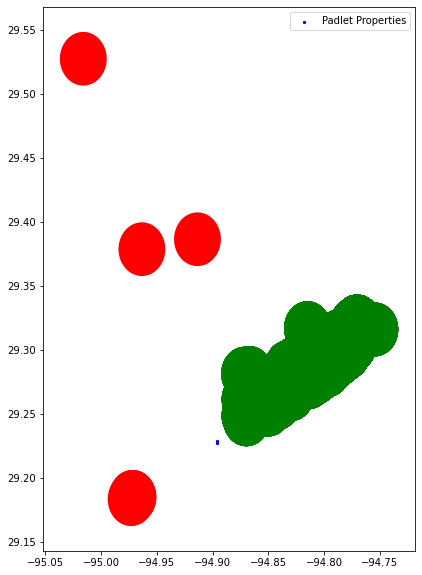

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_padlet.plot(ax=ax, color='blue', markersize=5, label='Padlet Properties')
gdf_tx_apar.plot(ax=ax, color='red', markersize=5, label='API Properties')
matches.plot(ax=ax, color='green', markersize=10, label='Matched Properties')
plt.legend()
plt.show()